**TRAIN TEST SPLIT**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from google.colab import files


df = pd.read_csv("/content/sample_data/Final_DHOW_Dataset_Tamil_CN -Final.csv")


X = df.drop('COUNTER NARRATIVES', axis=1)
y = df['COUNTER NARRATIVES']


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=5300,
    test_size=128,
    random_state=42,
    shuffle=True
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


train_df = pd.concat([X_train, y_train], axis=1)
test_df = X_test.copy()


train_path = "train_set.csv"
test_path = "test_set.csv"

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)


files.download(train_path)
files.download(test_path)


Train shape: (5300, 3) (5300,)
Test shape: (128, 3) (128,)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**MODEL COMPARISON**

In [ ]:
# ==== INSTALLS ====
!pip install -q pandas numpy nltk rouge-score bert-score openpyxl

import pandas as pd
import numpy as np
import re
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from bert_score import score as bert_score
import nltk

# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# ==== UPLOAD FILE ====
from google.colab import files
uploaded = files.upload()  # Upload Model_comparison_Journal.xlsx

file_path = list(uploaded.keys())[0]
df = pd.read_excel(file_path, sheet_name="Sheet1")

# ==== NORMALIZATION ====
def normalize_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# ==== METRICS FUNCTION ====
def compute_metrics(refs, hyps):
    smooth = SmoothingFunction().method1

    # BLEU
    bleu1 = np.mean([sentence_bleu([r.split()], h.split(), weights=(1,0,0,0), smoothing_function=smooth) for r,h in zip(refs, hyps)])
    bleu2 = np.mean([sentence_bleu([r.split()], h.split(), weights=(0.5,0.5,0,0), smoothing_function=smooth) for r,h in zip(refs, hyps)])
    bleu3 = np.mean([sentence_bleu([r.split()], h.split(), weights=(1/3,1/3,1/3,0), smoothing_function=smooth) for r,h in zip(refs, hyps)])
    bleu4 = np.mean([sentence_bleu([r.split()], h.split(), weights=(0.25,0.25,0.25,0.25), smoothing_function=smooth) for r,h in zip(refs, hyps)])

    # METEOR (tokenized inputs)
    meteor = np.mean([meteor_score([r.split()], h.split()) for r,h in zip(refs, hyps)])

    # ROUGE-L
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_l = np.mean([rouge.score(r, h)['rougeL'].fmeasure for r,h in zip(refs, hyps)])

    # BERTScore
    P, R, F1 = bert_score(hyps, refs, lang="multilingual", rescale_with_baseline=True)
    bert_f1 = float(F1.mean())

    return {
        "BLEU-1": bleu1,
        "BLEU-2": bleu2,
        "BLEU-3": bleu3,
        "BLEU-4": bleu4,
        "METEOR": meteor,
        "ROUGE-L": rouge_l,
        "BERTScore": bert_f1
    }

# ==== PREPARE DATA ====
refs = [normalize_text(x) for x in df["SEED DATASET COUNTER NARRATIVES"]]

models = {
    "GPT": [normalize_text(x) for x in df["GPT COUNTER NARRATIVES"]],
    "Gemini": [normalize_text(x) for x in df["GEMINI COUNTER NARRATIVES"]],
    "Grok": [normalize_text(x) for x in df["GROK COUNTER NARRATIVES"]],
    "DeepSeek": [normalize_text(x) for x in df["DEEPSEEK COUNTER NARRATIVES"]]
}

# ==== RUN METRICS ====
results = {}
for model_name, hyps in models.items():
    results[model_name] = compute_metrics(refs, hyps)

metrics_df = pd.DataFrame(results).T.round(3)

# ==== SHOW RESULTS ====
print("\n=== Model Comparison Metrics ===")
display(metrics_df.style.format("{:.3f}"))
print(metrics_df.to_string())


Saving Model_comparison_Journal.xlsx to Model_comparison_Journal (1).xlsx



=== Model Comparison Metrics ===


,BLEU-1,BLEU-2,BLEU-3,BLEU-4,METEOR,ROUGE-L,BERTScore
GPT,0.011,0.004,0.003,0.002,0.008,0.000,0.661
Gemini,0.033,0.009,0.006,0.005,0.024,0.000,0.663
Grok,0.010,0.004,0.003,0.002,0.010,0.000,0.661
DeepSeek,0.013,0.004,0.003,0.002,0.010,0.000,0.652


          BLEU-1  BLEU-2  BLEU-3  BLEU-4  METEOR  ROUGE-L  BERTScore
GPT        0.011   0.004   0.003   0.002   0.008      0.0      0.661
Gemini     0.033   0.009   0.006   0.005   0.024      0.0      0.663
Grok       0.010   0.004   0.003   0.002   0.010      0.0      0.661
DeepSeek   0.013   0.004   0.003   0.002   0.010      0.0      0.652


In [ ]:
# === Colab: comparison + non-comparison + composite ranking ===
!pip install -q pandas numpy nltk rouge-score bert-score openpyxl detoxify

import re, math, os
from collections import Counter
from itertools import chain
import numpy as np
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from detoxify import Detoxify

# NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# ---- Upload your Excel ----
from google.colab import files
uploaded = files.upload()   # pick Model_comparison_Journal.xlsx
xlsx_path = list(uploaded.keys())[0]

# ---- Load data (expects columns like in your sheet) ----
df = pd.read_excel(xlsx_path, sheet_name="Sheet1")

# Column helpers
def col(df, name_part):
    for c in df.columns:
        if name_part.lower() in c.lower():
            return c
    return None

COL_HS   = col(df, "TEXT")
COL_REF  = col(df, "SEED DATASET COUNTER")
COL_GPT  = col(df, "GPT COUNTER")
COL_GEM  = col(df, "GEMINI COUNTER")
COL_GROK = col(df, "GROK COUNTER")
COL_DEEP = col(df, "DEEPSEEK COUNTER")

assert all([COL_HS, COL_REF, COL_GPT, COL_GEM, COL_GROK, COL_DEEP]), "Missing expected columns in the sheet."

# ---- Normalization / tokenization ----
def normalize(s):
    if pd.isna(s): return ""
    s = str(s)
    s = re.sub(r"[\u200B-\u200D\uFEFF]", "", s)   # zero-width
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tok(s):
    return normalize(s).split()

refs = [normalize(x) for x in df[COL_REF]]
hs   = [normalize(x) for x in df[COL_HS]]

MODELS = {
    "GPT":      [normalize(x) for x in df[COL_GPT]],
    "Gemini":   [normalize(x) for x in df[COL_GEM]],
    "Grok":     [normalize(x) for x in df[COL_GROK]],
    "DeepSeek": [normalize(x) for x in df[COL_DEEP]],
}

# ---- Comparison metrics ----
smooth = SmoothingFunction().method1
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def comp_metrics(refs, hyps):
    # BLEU (avg sentence BLEU with smoothing)
    bleu1 = np.mean([sentence_bleu([tok(r)], tok(h), weights=(1,0,0,0), smoothing_function=smooth) for r,h in zip(refs, hyps)])
    bleu2 = np.mean([sentence_bleu([tok(r)], tok(h), weights=(0.5,0.5,0,0), smoothing_function=smooth) for r,h in zip(refs, hyps)])
    bleu3 = np.mean([sentence_bleu([tok(r)], tok(h), weights=(1/3,1/3,1/3,0), smoothing_function=smooth) for r,h in zip(refs, hyps)])
    bleu4 = np.mean([sentence_bleu([tok(r)], tok(h), weights=(0.25,0.25,0.25,0.25), smoothing_function=smooth) for r,h in zip(refs, hyps)])

    meteor = np.mean([meteor_score([tok(r)], tok(h)) for r,h in zip(refs, hyps)])
    rougeL = np.mean([rouge.score(r,h)['rougeL'].fmeasure for r,h in zip(refs, hyps)])

    # BERTScore (multilingual)
    P,R,F1 = bert_score(hyps, refs, lang="multilingual", rescale_with_baseline=True)
    bertF1 = float(F1.mean())

    return {"BLEU-1":bleu1, "BLEU-2":bleu2, "BLEU-3":bleu3, "BLEU-4":bleu4,
            "METEOR":meteor, "ROUGE-L":rougeL, "BERTScore":bertF1}

# ---- Non-comparison metrics ----
def distinct_n(texts, n=1):
    grams = list(chain.from_iterable([list(zip(*[tok(t)[i:] for i in range(n)])) if len(tok(t))>=n else [] for t in texts]))
    if not grams: return 0.0
    return len(set(grams))/len(grams)

def novelty_list(hs_list, cn_list):
    vals=[]
    for h,c in zip(hs_list, cn_list):
        A, B = set(tok(h)), set(tok(c))
        den = len(A|B)
        vals.append(0.0 if den==0 else 1 - len(A&B)/den)
    return float(np.mean(vals))

tox_model = Detoxify('multilingual')
def toxicity_scores(texts, threshold=0.5):
    preds = tox_model.predict(texts)
    scores = preds["toxicity"] if "toxicity" in preds else np.max(np.vstack(list(preds.values())), axis=0)
    scores = np.array(scores)
    rate = float(np.mean(scores > threshold))
    return 1.0 - rate, rate  # Non-Abusive, ToxicityRate

# ---- Compute all metrics ----
rows_comp = []
rows_non  = []
for model, hyps in MODELS.items():
    c = comp_metrics(refs, hyps)
    rows_comp.append({"Model":model, **c})

    nov   = novelty_list(hs, hyps)
    d1    = distinct_n(hyps, n=1)
    d2    = distinct_n(hyps, n=2)
    nonab, toxr = toxicity_scores(hyps, threshold=0.5)
    rows_non.append({"Model":model, "Novelty":nov, "Distinct-1":d1, "Distinct-2":d2,
                     "Non-Abusive":nonab, "ToxicityRate":toxr})

comp_df = pd.DataFrame(rows_comp).set_index("Model").round(3)
non_df  = pd.DataFrame(rows_non).set_index("Model").round(3)

print("=== Comparison metrics (vs seed CN) ===")
display(comp_df.style.format("{:.3f}"))
print(comp_df.to_string(), "\n")

print("=== Non-comparison metrics ===")
display(non_df.style.format("{:.3f}"))
print(non_df.to_string(), "\n")

# ---- Composite score (adjust weights here) ----
WEIGHTS = {
    # comparison
    "BERTScore": 0.35,
    "METEOR":    0.10,
    "ROUGE-L":   0.05,
    "BLEU-1":    0.05,
    "BLEU-2":    0.05,
    "BLEU-3":    0.05,
    "BLEU-4":    0.05,
    # non-comparison
    "Novelty":     0.10,
    "Distinct-1":  0.10,
    "Distinct-2":  0.05,
    "Non-Abusive": 0.05,
    # ToxicityRate is *penalized* below
}

# Merge and compute composite (penalize toxicity)
all_df = comp_df.join(non_df, how="inner")
# Normalize ToxicityRate into a penalty term (lower is better)
all_df["ToxicityPenalty"] = 1.0 - all_df["ToxicityRate"]

# Ensure all weights sum <= 1.0; ToxicityPenalty can be folded into weights if you want
# Example: include penalty via small extra weight (already captured via Non-Abusive; we leave it informative)

# Composite score
def composite(row):
    score = 0.0
    for k,w in WEIGHTS.items():
        score += float(row[k]) * w
    return score

all_df["CompositeScore"] = all_df.apply(composite, axis=1)
ranked = all_df.sort_values("CompositeScore", ascending=False).round(3)

print("=== Composite metrics (with weights) ===")
display(ranked[ list(WEIGHTS.keys()) + ["ToxicityRate","CompositeScore"] ])
print(ranked[ list(WEIGHTS.keys()) + ["ToxicityRate","CompositeScore"] ].to_string(), "\n")

print("=== Ranking ===")
for i,(m,r) in enumerate(ranked["CompositeScore"].items(), start=1):
    print(f"{i}. {m}: {r:.3f}")

print("\nTip: tweak WEIGHTS dict above to reflect your evaluation focus (e.g., increase Novelty/Distinct/Non-Abusive if you value diversity & safety more; increase BERTScore/METEOR if you value closeness to seed).")


Saving Model_comparison_Journal.xlsx to Model_comparison_Journal (2).xlsx


=== Comparison metrics (vs seed CN) ===


,BLEU-1,BLEU-2,BLEU-3,BLEU-4,METEOR,ROUGE-L,BERTScore
Model,,,,,,,
GPT,0.011,0.004,0.003,0.002,0.008,0.000,0.661
Gemini,0.033,0.009,0.006,0.005,0.024,0.000,0.663
Grok,0.010,0.004,0.003,0.002,0.010,0.000,0.661
DeepSeek,0.013,0.004,0.003,0.002,0.010,0.000,0.652


          BLEU-1  BLEU-2  BLEU-3  BLEU-4  METEOR  ROUGE-L  BERTScore
Model                                                               
GPT        0.011   0.004   0.003   0.002   0.008      0.0      0.661
Gemini     0.033   0.009   0.006   0.005   0.024      0.0      0.663
Grok       0.010   0.004   0.003   0.002   0.010      0.0      0.661
DeepSeek   0.013   0.004   0.003   0.002   0.010      0.0      0.652 

=== Non-comparison metrics ===


,Novelty,Distinct-1,Distinct-2,Non-Abusive,ToxicityRate
Model,,,,,
GPT,0.989,0.856,0.984,1.000,0.000
Gemini,0.969,0.773,0.966,1.000,0.000
Grok,0.953,0.776,0.943,1.000,0.000
DeepSeek,0.992,0.850,0.951,1.000,0.000


          Novelty  Distinct-1  Distinct-2  Non-Abusive  ToxicityRate
Model                                                               
GPT         0.989       0.856       0.984          1.0           0.0
Gemini      0.969       0.773       0.966          1.0           0.0
Grok        0.953       0.776       0.943          1.0           0.0
DeepSeek    0.992       0.850       0.951          1.0           0.0 

=== Composite metrics (with weights) ===


,BERTScore,METEOR,ROUGE-L,BLEU-1,BLEU-2,BLEU-3,BLEU-4,Novelty,Distinct-1,Distinct-2,Non-Abusive,ToxicityRate,CompositeScore
Model,,,,,,,,,,,,,
GPT,0.661,0.008,0.0,0.011,0.004,0.003,0.002,0.989,0.856,0.984,1.0,0.0,0.517
DeepSeek,0.652,0.010,0.0,0.013,0.004,0.003,0.002,0.992,0.850,0.951,1.0,0.0,0.512
Gemini,0.663,0.024,0.0,0.033,0.009,0.006,0.005,0.969,0.773,0.966,1.0,0.0,0.510
Grok,0.661,0.010,0.0,0.010,0.004,0.003,0.002,0.953,0.776,0.943,1.0,0.0,0.503


          BERTScore  METEOR  ROUGE-L  BLEU-1  BLEU-2  BLEU-3  BLEU-4  Novelty  Distinct-1  Distinct-2  Non-Abusive  ToxicityRate  CompositeScore
Model                                                                                                                                           
GPT           0.661   0.008      0.0   0.011   0.004   0.003   0.002    0.989       0.856       0.984          1.0           0.0           0.517
DeepSeek      0.652   0.010      0.0   0.013   0.004   0.003   0.002    0.992       0.850       0.951          1.0           0.0           0.512
Gemini        0.663   0.024      0.0   0.033   0.009   0.006   0.005    0.969       0.773       0.966          1.0           0.0           0.510
Grok          0.661   0.010      0.0   0.010   0.004   0.003   0.002    0.953       0.776       0.943          1.0           0.0           0.503 

=== Ranking ===
1. GPT: 0.517
2. DeepSeek: 0.512
3. Gemini: 0.510
4. Grok: 0.503

Tip: tweak WEIGHTS dict above to reflect your 

In [ ]:
# === Colab: adds CHARACTER-level ROUGE-L for Tamil ===
!pip install -q pandas numpy nltk rouge-score bert-score openpyxl

import re
import numpy as np
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from bert_score import score as bert_score

# NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# ---- Upload Excel ----
from google.colab import files
uploaded = files.upload()  # upload Model_comparison_Journal.xlsx
xlsx_path = list(uploaded.keys())[0]
df = pd.read_excel(xlsx_path, sheet_name="Sheet1")

# ---- Helpers ----
def normalize(s):
    if pd.isna(s): return ""
    s = str(s)
    s = re.sub(r"[\u200B-\u200D\uFEFF]", "", s)  # zero-width
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tok(s):  # simple whitespace tokenization
    return normalize(s).split()

# Character-level ROUGE-L (LCS-based F1)
def rouge_l_char_f1(ref, hyp):
    a = list(normalize(ref))
    b = list(normalize(hyp))
    m, n = len(a), len(b)
    if m == 0 and n == 0: return 1.0
    # LCS DP
    dp = [0]*(n+1)
    for i in range(1, m+1):
        prev = 0
        for j in range(1, n+1):
            tmp = dp[j]
            if a[i-1] == b[j-1]:
                dp[j] = prev + 1
            else:
                dp[j] = max(dp[j], dp[j-1])
            prev = tmp
    lcs = dp[n]
    r = lcs / (m if m else 1)
    p = lcs / (n if n else 1)
    return 0.0 if (r+p)==0 else (2*r*p)/(r+p)

# ---- Columns ----
def col(df, part):
    for c in df.columns:
        if part.lower() in c.lower(): return c
    return None

COL_REF  = col(df, "SEED DATASET COUNTER")
COL_GPT  = col(df, "GPT COUNTER")
COL_GEM  = col(df, "GEMINI COUNTER")
COL_GROK = col(df, "GROK COUNTER")
COL_DEEP = col(df, "DEEPSEEK COUNTER")
assert all([COL_REF, COL_GPT, COL_GEM, COL_GROK, COL_DEEP]), "Missing expected columns."

refs = [normalize(x) for x in df[COL_REF]]
models = {
    "GPT":      [normalize(x) for x in df[COL_GPT]],
    "Gemini":   [normalize(x) for x in df[COL_GEM]],
    "Grok":     [normalize(x) for x in df[COL_GROK]],
    "DeepSeek": [normalize(x) for x in df[COL_DEEP]],
}

smooth = SmoothingFunction().method1
rouge_word = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def compute_metrics(refs, hyps):
    # BLEU
    bleu1 = np.mean([sentence_bleu([tok(r)], tok(h), weights=(1,0,0,0), smoothing_function=smooth) for r,h in zip(refs, hyps)])
    bleu2 = np.mean([sentence_bleu([tok(r)], tok(h), weights=(0.5,0.5,0,0), smoothing_function=smooth) for r,h in zip(refs, hyps)])
    bleu3 = np.mean([sentence_bleu([tok(r)], tok(h), weights=(1/3,1/3,1/3,0), smoothing_function=smooth) for r,h in zip(refs, hyps)])
    bleu4 = np.mean([sentence_bleu([tok(r)], tok(h), weights=(0.25,0.25,0.25,0.25), smoothing_function=smooth) for r,h in zip(refs, hyps)])
    # METEOR (tokenized)
    meteor = np.mean([meteor_score([tok(r)], tok(h)) for r,h in zip(refs, hyps)])
    # ROUGE-L (word-level, may be ~0 for Tamil)
    rougeL_word = np.mean([rouge_word.score(r, h)['rougeL'].fmeasure for r,h in zip(refs, hyps)])
    # ROUGE-L (character-level) – this should give meaningful non-zero scores
    rougeL_char = np.mean([rouge_l_char_f1(r, h) for r,h in zip(refs, hyps)])
    # BERTScore (semantic)
    P,R,F1 = bert_score(hyps, refs, lang="multilingual", rescale_with_baseline=True)
    bertF1 = float(F1.mean())
    return {
        "BLEU-1": bleu1, "BLEU-2": bleu2, "BLEU-3": bleu3, "BLEU-4": bleu4,
        "METEOR": meteor,
        "ROUGE-L(word)": rougeL_word,
        "ROUGE-L(char)": rougeL_char,
        "BERTScore": bertF1
    }

# Run
rows = []
for name, hyps in models.items():
    rows.append({"Model": name, **compute_metrics(refs, hyps)})

out = pd.DataFrame(rows).set_index("Model").round(3)
print("=== Metrics (with character-level ROUGE-L) ===")
display(out.style.format("{:.3f}"))
print(out.to_string())


Saving Model_comparison_Journal.xlsx to Model_comparison_Journal (3).xlsx


=== Metrics (with character-level ROUGE-L) ===


,BLEU-1,BLEU-2,BLEU-3,BLEU-4,METEOR,ROUGE-L(word),ROUGE-L(char),BERTScore
Model,,,,,,,,
GPT,0.011,0.004,0.003,0.002,0.008,0.000,0.365,0.661
Gemini,0.033,0.009,0.006,0.005,0.024,0.000,0.352,0.663
Grok,0.010,0.004,0.003,0.002,0.010,0.000,0.351,0.661
DeepSeek,0.013,0.004,0.003,0.002,0.010,0.000,0.342,0.652


          BLEU-1  BLEU-2  BLEU-3  BLEU-4  METEOR  ROUGE-L(word)  ROUGE-L(char)  BERTScore
Model                                                                                    
GPT        0.011   0.004   0.003   0.002   0.008            0.0          0.365      0.661
Gemini     0.033   0.009   0.006   0.005   0.024            0.0          0.352      0.663
Grok       0.010   0.004   0.003   0.002   0.010            0.0          0.351      0.661
DeepSeek   0.013   0.004   0.003   0.002   0.010            0.0          0.342      0.652


In [ ]:
# === All score tables: comparison + non-comparison + composite + ranking ===
!pip install -q pandas numpy nltk rouge-score bert-score openpyxl detoxify

import re, math
from collections import Counter
from itertools import chain

import numpy as np
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from detoxify import Detoxify

# NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# ---- Upload Excel ----
from google.colab import files
uploaded = files.upload()  # pick Model_comparison_Journal.xlsx
xlsx_path = list(uploaded.keys())[0]
df = pd.read_excel(xlsx_path, sheet_name="Sheet1")

# ---- Column helpers ----
def col(df, part):
    for c in df.columns:
        if part.lower() in c.lower(): return c
    return None

COL_HS   = col(df, "TEXT")
COL_REF  = col(df, "SEED DATASET COUNTER")
COL_GPT  = col(df, "GPT COUNTER")
COL_GEM  = col(df, "GEMINI COUNTER")
COL_GROK = col(df, "GROK COUNTER")
COL_DEEP = col(df, "DEEPSEEK COUNTER")
assert all([COL_REF, COL_GPT, COL_GEM, COL_GROK, COL_DEEP]), "Missing expected columns."

# ---- Normalize / tokenize ----
def normalize(s):
    if pd.isna(s): return ""
    s = str(s)
    s = re.sub(r"[\u200B-\u200D\uFEFF]", "", s)  # zero-width
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tok(s):  # simple whitespace tokens (Tamil works ok for our metrics)
    return normalize(s).split()

refs = [normalize(x) for x in df[COL_REF]]
hs   = [normalize(x) for x in df[COL_HS]] if COL_HS else [""]*len(refs)

MODELS = {
    "GPT":      [normalize(x) for x in df[COL_GPT]],
    "Gemini":   [normalize(x) for x in df[COL_GEM]],
    "Grok":     [normalize(x) for x in df[COL_GROK]],
    "DeepSeek": [normalize(x) for x in df[COL_DEEP]],
}

# ---- Character-level ROUGE-L (for Tamil) ----
def rouge_l_char_f1(ref, hyp):
    a = list(normalize(ref)); b = list(normalize(hyp))
    m, n = len(a), len(b)
    if m == 0 and n == 0: return 1.0
    dp = [0]*(n+1)
    for i in range(1, m+1):
        prev = 0
        for j in range(1, n+1):
            tmp = dp[j]
            if a[i-1] == b[j-1]: dp[j] = prev + 1
            else: dp[j] = max(dp[j], dp[j-1])
            prev = tmp
    lcs = dp[n]
    r = lcs / (m if m else 1)
    p = lcs / (n if n else 1)
    return 0.0 if (r+p)==0 else (2*r*p)/(r+p)

# ---- Metric engines ----
smooth = SmoothingFunction().method1
rouge_word = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
tox_model = Detoxify('multilingual')
TOX_THRESHOLD = 0.5

# ---- Comparison metrics (vs seed CN) ----
def comparison_metrics(refs, hyps):
    bleu1 = np.mean([sentence_bleu([tok(r)], tok(h), weights=(1,0,0,0), smoothing_function=smooth) for r,h in zip(refs, hyps)])
    bleu2 = np.mean([sentence_bleu([tok(r)], tok(h), weights=(0.5,0.5,0,0), smoothing_function=smooth) for r,h in zip(refs, hyps)])
    bleu3 = np.mean([sentence_bleu([tok(r)], tok(h), weights=(1/3,1/3,1/3,0), smoothing_function=smooth) for r,h in zip(refs, hyps)])
    bleu4 = np.mean([sentence_bleu([tok(r)], tok(h), weights=(0.25,0.25,0.25,0.25), smoothing_function=smooth) for r,h in zip(refs, hyps)])
    meteor = np.mean([meteor_score([tok(r)], tok(h)) for r,h in zip(refs, hyps)])
    rougeL_word = np.mean([rouge_word.score(r, h)['rougeL'].fmeasure for r,h in zip(refs, hyps)])
    rougeL_char = np.mean([rouge_l_char_f1(r, h) for r,h in zip(refs, hyps)])
    P, R, F1 = bert_score(hyps, refs, lang="multilingual", rescale_with_baseline=True)
    bertF1 = float(F1.mean())
    return {"BLEU-1":bleu1,"BLEU-2":bleu2,"BLEU-3":bleu3,"BLEU-4":bleu4,
            "METEOR":meteor,"ROUGE-L(word)":rougeL_word,"ROUGE-L(char)":rougeL_char,
            "BERTScore":bertF1}

# ---- Non-comparison metrics (no reference) ----
def distinct_n(texts, n=1):
    grams = list(chain.from_iterable(
        [list(zip(*[tok(t)[i:] for i in range(n)])) if len(tok(t))>=n else [] for t in texts]
    ))
    return 0.0 if not grams else len(set(grams))/len(grams)

def novelty_vals(hs_list, cn_list):
    vals=[]
    for h,c in zip(hs_list, cn_list):
        A, B = set(tok(h)), set(tok(c))
        den = len(A|B)
        vals.append(0.0 if den==0 else 1 - len(A&B)/den)
    return float(np.mean(vals))

def safety_scores(texts, threshold=TOX_THRESHOLD):
    preds = tox_model.predict(texts)
    scores = preds["toxicity"] if "toxicity" in preds else np.max(np.vstack(list(preds.values())), axis=0)
    scores = np.array(scores)
    tox_rate = float(np.mean(scores > threshold))
    return 1.0 - tox_rate, tox_rate  # Non-Abusive, ToxicityRate

# ---- Compute & print tables ----
comp_rows, non_rows = [], []
for name, hyps in MODELS.items():
    comp_rows.append({"Model":name, **comparison_metrics(refs, hyps)})
    nov = novelty_vals(hs, hyps)
    d1  = distinct_n(hyps, n=1)
    d2  = distinct_n(hyps, n=2)
    nonab, toxr = safety_scores(hyps)
    non_rows.append({"Model":name, "Novelty":nov, "Distinct-1":d1, "Distinct-2":d2,
                     "Non-Abusive":nonab, "ToxicityRate":toxr})

comp_df = pd.DataFrame(comp_rows).set_index("Model").round(3)
non_df  = pd.DataFrame(non_rows).set_index("Model").round(3)

print("=== Comparison metrics (vs seed CN) ===")
display(comp_df.style.format("{:.3f}"))
print(comp_df.to_string(), "\n")

print("=== Non-comparison metrics ===")
display(non_df.style.format("{:.3f}"))
print(non_df.to_string(), "\n")

# ---- Composite (optional): tweak weights to your study’s priorities ----
WEIGHTS = {
    "BERTScore":      0.30,
    "METEOR":         0.10,
    "ROUGE-L(char)":  0.10,
    "BLEU-1":         0.05,
    "BLEU-2":         0.05,
    "BLEU-3":         0.05,
    "BLEU-4":         0.05,
    "Novelty":        0.10,
    "Distinct-1":     0.10,
    "Distinct-2":     0.05,
    "Non-Abusive":    0.05,
}
all_df = comp_df.join(non_df, how="inner")
def composite(row): return sum(float(row[k])*w for k,w in WEIGHTS.items())
all_df["CompositeScore"] = all_df.apply(composite, axis=1)
ranked = all_df.sort_values("CompositeScore", ascending=False).round(3)

print("=== Composite (with weights) + Ranking ===")
display(ranked[list(WEIGHTS.keys()) + ["ToxicityRate","CompositeScore"]])
print(ranked[list(WEIGHTS.keys()) + ["ToxicityRate","CompositeScore"]].to_string(), "\n")

print("=== Ranking ===")
for i,(m,score) in enumerate(ranked["CompositeScore"].items(), start=1):
    print(f"{i}. {m}: {score:.3f}")

# (Optional) Save CSVs
# comp_df.to_csv("comparison_metrics.csv")
# non_df.to_csv("non_comparison_metrics.csv")
# ranked.to_csv("composite_and_ranking.csv")


Saving Model_comparison_Journal.xlsx to Model_comparison_Journal (4).xlsx


=== Comparison metrics (vs seed CN) ===


,BLEU-1,BLEU-2,BLEU-3,BLEU-4,METEOR,ROUGE-L(word),ROUGE-L(char),BERTScore
Model,,,,,,,,
GPT,0.011,0.004,0.003,0.002,0.008,0.000,0.365,0.661
Gemini,0.033,0.009,0.006,0.005,0.024,0.000,0.352,0.663
Grok,0.010,0.004,0.003,0.002,0.010,0.000,0.351,0.661
DeepSeek,0.013,0.004,0.003,0.002,0.010,0.000,0.342,0.652


          BLEU-1  BLEU-2  BLEU-3  BLEU-4  METEOR  ROUGE-L(word)  ROUGE-L(char)  BERTScore
Model                                                                                    
GPT        0.011   0.004   0.003   0.002   0.008            0.0          0.365      0.661
Gemini     0.033   0.009   0.006   0.005   0.024            0.0          0.352      0.663
Grok       0.010   0.004   0.003   0.002   0.010            0.0          0.351      0.661
DeepSeek   0.013   0.004   0.003   0.002   0.010            0.0          0.342      0.652 

=== Non-comparison metrics ===


,Novelty,Distinct-1,Distinct-2,Non-Abusive,ToxicityRate
Model,,,,,
GPT,0.989,0.856,0.984,1.000,0.000
Gemini,0.969,0.773,0.966,1.000,0.000
Grok,0.953,0.776,0.943,1.000,0.000
DeepSeek,0.992,0.850,0.951,1.000,0.000


          Novelty  Distinct-1  Distinct-2  Non-Abusive  ToxicityRate
Model                                                               
GPT         0.989       0.856       0.984          1.0           0.0
Gemini      0.969       0.773       0.966          1.0           0.0
Grok        0.953       0.776       0.943          1.0           0.0
DeepSeek    0.992       0.850       0.951          1.0           0.0 

=== Composite (with weights) + Ranking ===


,BERTScore,METEOR,ROUGE-L(char),BLEU-1,BLEU-2,BLEU-3,BLEU-4,Novelty,Distinct-1,Distinct-2,Non-Abusive,ToxicityRate,CompositeScore
Model,,,,,,,,,,,,,
GPT,0.661,0.008,0.365,0.011,0.004,0.003,0.002,0.989,0.856,0.984,1.0,0.0,0.520
DeepSeek,0.652,0.010,0.342,0.013,0.004,0.003,0.002,0.992,0.850,0.951,1.0,0.0,0.514
Gemini,0.663,0.024,0.352,0.033,0.009,0.006,0.005,0.969,0.773,0.966,1.0,0.0,0.512
Grok,0.661,0.010,0.351,0.010,0.004,0.003,0.002,0.953,0.776,0.943,1.0,0.0,0.505


          BERTScore  METEOR  ROUGE-L(char)  BLEU-1  BLEU-2  BLEU-3  BLEU-4  Novelty  Distinct-1  Distinct-2  Non-Abusive  ToxicityRate  CompositeScore
Model                                                                                                                                                 
GPT           0.661   0.008          0.365   0.011   0.004   0.003   0.002    0.989       0.856       0.984          1.0           0.0           0.520
DeepSeek      0.652   0.010          0.342   0.013   0.004   0.003   0.002    0.992       0.850       0.951          1.0           0.0           0.514
Gemini        0.663   0.024          0.352   0.033   0.009   0.006   0.005    0.969       0.773       0.966          1.0           0.0           0.512
Grok          0.661   0.010          0.351   0.010   0.004   0.003   0.002    0.953       0.776       0.943          1.0           0.0           0.505 

=== Ranking ===
1. GPT: 0.520
2. DeepSeek: 0.514
3. Gemini: 0.512
4. Grok: 0.505


In [ ]:
# === Toxicity breakdown only (per model, per category) ===
!pip install -q pandas numpy openpyxl detoxify

import re
import numpy as np
import pandas as pd
from detoxify import Detoxify

# ---- Upload the Excel ----
from google.colab import files
uploaded = files.upload()  # choose Model_comparison_Journal.xlsx
xlsx_path = list(uploaded.keys())[0]

# ---- Load data ----
df = pd.read_excel(xlsx_path, sheet_name="Sheet1")

def find_col(part):
    for c in df.columns:
        if part.lower() in c.lower():
            return c
    return None

COL_GPT  = find_col("GPT COUNTER")
COL_GEM  = find_col("GEMINI COUNTER")
COL_GROK = find_col("GROK COUNTER")
COL_DEEP = find_col("DEEPSEEK COUNTER")
assert all([COL_GPT, COL_GEM, COL_GROK, COL_DEEP]), "Missing expected model columns."

def normalize(s):
    if pd.isna(s): return ""
    s = re.sub(r"[\u200B-\u200D\uFEFF]", "", str(s))  # strip zero-width
    return re.sub(r"\s+", " ", s).strip()

MODELS = {
    "GPT":      [normalize(x) for x in df[COL_GPT]],
    "Gemini":   [normalize(x) for x in df[COL_GEM]],
    "Grok":     [normalize(x) for x in df[COL_GROK]],
    "DeepSeek": [normalize(x) for x in df[COL_DEEP]],
}

# ---- Run Detoxify (multilingual) once per model ----
tox = Detoxify('multilingual')  # categories: toxicity, severe_toxicity, obscene, identity_attack, insult, threat, sexual_explicit

ALL_KEYS = ["toxicity","severe_toxicity","obscene","threat","insult","identity_attack","identity_hate","sexual_explicit"]
KEY_REMAP = {  # unify naming to a consistent set
    "identity_attack": "identity_hate"  # treat as identity_hate for reporting
}
THRESH = 0.50  # change if you want stricter/looser cutoff

avg_rows = []
rate_rows = []

for name, texts in MODELS.items():
    preds = tox.predict(texts)  # dict: key -> list/np.ndarray of scores
    # unify keys
    merged = {}
    for k, v in preds.items():
        out_k = KEY_REMAP.get(k, k)
        merged.setdefault(out_k, []).extend(list(v))

    # ensure all requested keys exist (fill zeros if missing)
    for k in ALL_KEYS:
        if k not in merged:
            merged[k] = [0.0]*len(texts)

    # build stats
    avg = {k: float(np.mean(merged[k])) for k in ALL_KEYS}
    rate = {k: float(np.mean(np.array(merged[k]) > THRESH)) for k in ALL_KEYS}

    avg_rows.append({"Model": name, **avg})
    rate_rows.append({"Model": name, **rate})

avg_df = pd.DataFrame(avg_rows).set_index("Model")
rate_df = pd.DataFrame(rate_rows).set_index("Model")

# keep a tidy column order
ordered_cols = ["toxicity","severe_toxicity","obscene","threat","insult","identity_hate","sexual_explicit"]
avg_df = avg_df[ordered_cols]
rate_df = rate_df[ordered_cols]

# round and show
avg_out  = avg_df.round(4)
rate_out = rate_df.round(3)

print(f"=== Detoxify (multilingual) – Average scores per category ===")
display(avg_out.style.format("{:.4f}"))
print(avg_out.to_string(), "\n")

print(f"=== Detoxify (multilingual) – Rate > {THRESH:.2f} per category ===")
display(rate_out.style.format("{:.3f}"))
print(rate_out.to_string(), "\n")

# (Optional) save CSVs
# avg_out.to_csv("toxicity_category_averages.csv")
# rate_out.to_csv("toxicity_category_rates.csv")


Saving Model_comparison_Journal.xlsx to Model_comparison_Journal (6).xlsx
=== Detoxify (multilingual) – Average scores per category ===


,toxicity,severe_toxicity,obscene,threat,insult,identity_hate,sexual_explicit
Model,,,,,,,
GPT,0.0004,0.0050,0.0305,0.0024,0.0256,0.0055,0.0010
Gemini,0.0005,0.0052,0.0323,0.0024,0.0281,0.0059,0.0009
Grok,0.0006,0.0045,0.0299,0.0020,0.0261,0.0054,0.0008
DeepSeek,0.0004,0.0049,0.0310,0.0023,0.0264,0.0056,0.0009


          toxicity  severe_toxicity  obscene  threat  insult  identity_hate  sexual_explicit
Model                                                                                       
GPT         0.0004           0.0050   0.0305  0.0024  0.0256         0.0055           0.0010
Gemini      0.0005           0.0052   0.0323  0.0024  0.0281         0.0059           0.0009
Grok        0.0006           0.0045   0.0299  0.0020  0.0261         0.0054           0.0008
DeepSeek    0.0004           0.0049   0.0310  0.0023  0.0264         0.0056           0.0009 

=== Detoxify (multilingual) – Rate > 0.50 per category ===


,toxicity,severe_toxicity,obscene,threat,insult,identity_hate,sexual_explicit
Model,,,,,,,
GPT,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Gemini,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Grok,0.000,0.000,0.000,0.000,0.000,0.000,0.000
DeepSeek,0.000,0.000,0.000,0.000,0.000,0.000,0.000


          toxicity  severe_toxicity  obscene  threat  insult  identity_hate  sexual_explicit
Model                                                                                       
GPT            0.0              0.0      0.0     0.0     0.0            0.0              0.0
Gemini         0.0              0.0      0.0     0.0     0.0            0.0              0.0
Grok           0.0              0.0      0.0     0.0     0.0            0.0              0.0
DeepSeek       0.0              0.0      0.0     0.0     0.0            0.0              0.0 



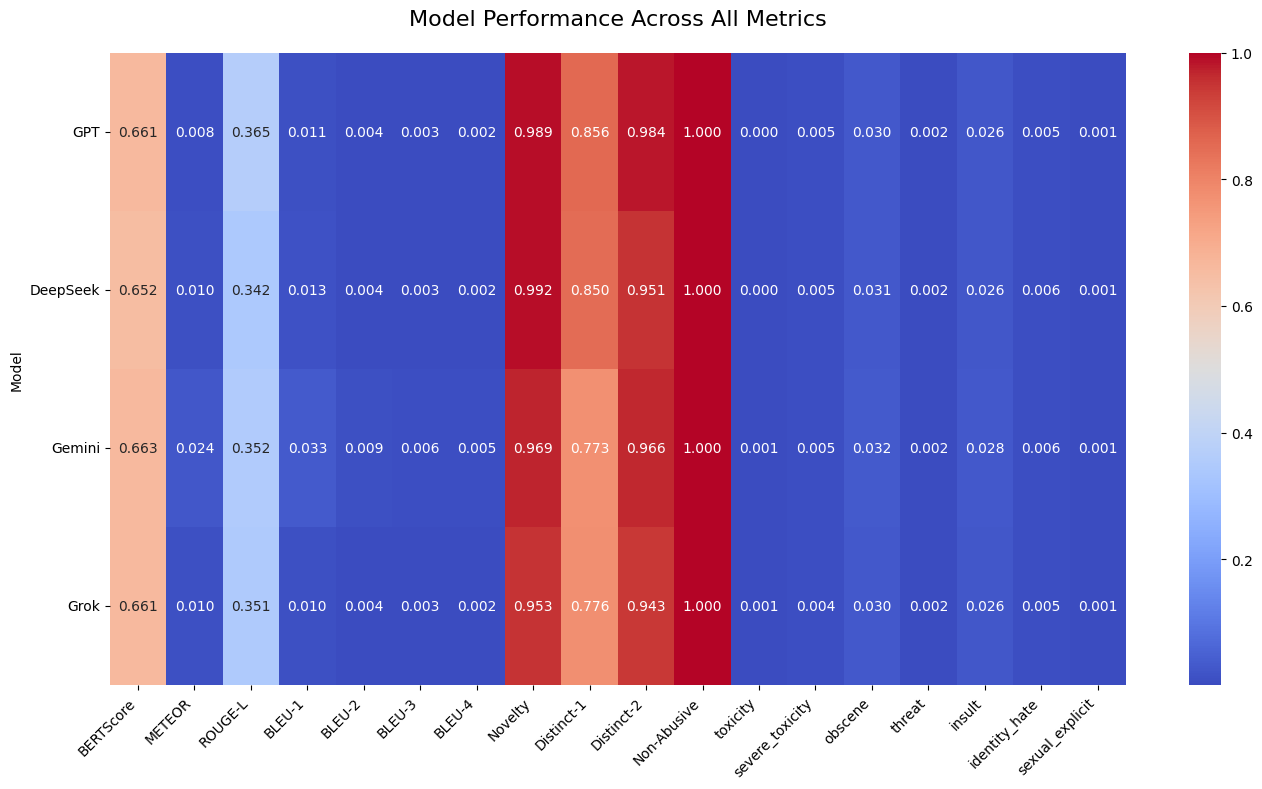

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Replace this with your actual combined metrics DataFrame
data = {
    "Model": ["GPT", "DeepSeek", "Gemini", "Grok"],
    "BERTScore": [0.661, 0.652, 0.663, 0.661],
    "METEOR": [0.008, 0.010, 0.024, 0.010],
    "ROUGE-L": [0.365, 0.342, 0.352, 0.351],
    "BLEU-1": [0.011, 0.013, 0.033, 0.010],
    "BLEU-2": [0.004, 0.004, 0.009, 0.004],
    "BLEU-3": [0.003, 0.003, 0.006, 0.003],
    "BLEU-4": [0.002, 0.002, 0.005, 0.002],
    "Novelty": [0.989, 0.992, 0.969, 0.953],
    "Distinct-1": [0.856, 0.850, 0.773, 0.776],
    "Distinct-2": [0.984, 0.951, 0.966, 0.943],
    "Non-Abusive": [1.0, 1.0, 1.0, 1.0],
    "toxicity": [0.0004, 0.0004, 0.0005, 0.0006],
    "severe_toxicity": [0.0050, 0.0049, 0.0052, 0.0045],
    "obscene": [0.0305, 0.0310, 0.0323, 0.0299],
    "threat": [0.0024, 0.0023, 0.0024, 0.0020],
    "insult": [0.0256, 0.0264, 0.0281, 0.0261],
    "identity_hate": [0.0055, 0.0056, 0.0059, 0.0054],
    "sexual_explicit": [0.0010, 0.0009, 0.0009, 0.0008]
}

df = pd.DataFrame(data)
df.set_index("Model", inplace=True)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(df, annot=True, fmt=".3f", cmap="coolwarm", cbar=True)

plt.title("Model Performance Across All Metrics", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


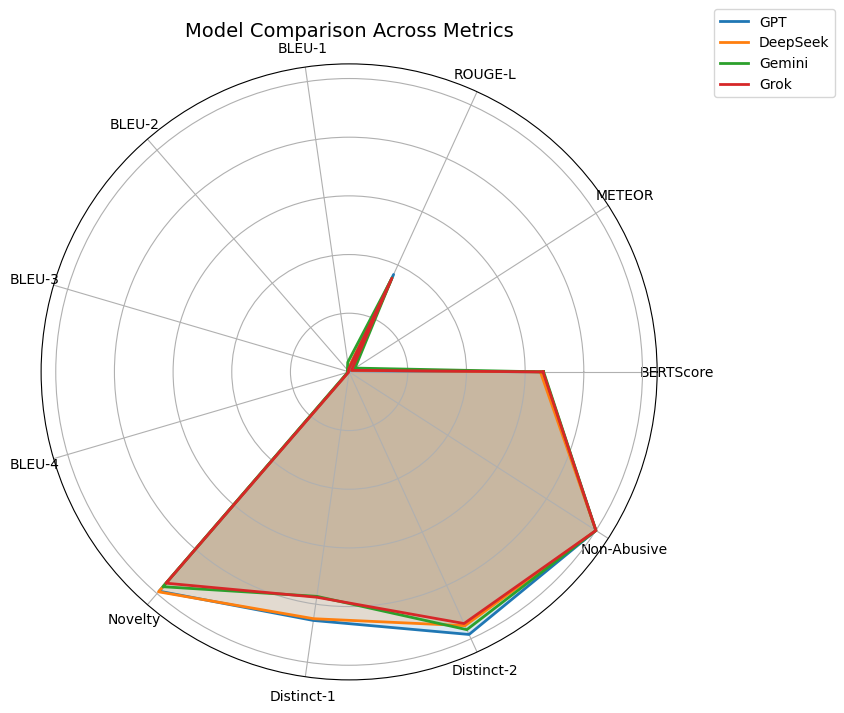

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example data — replace with your actual scores
data = {
    "Metric": ["BERTScore", "METEOR", "ROUGE-L", "BLEU-1", "BLEU-2", "BLEU-3", "BLEU-4",
               "Novelty", "Distinct-1", "Distinct-2", "Non-Abusive"],
    "GPT":      [0.661, 0.008, 0.365, 0.011, 0.004, 0.003, 0.002, 0.989, 0.856, 0.984, 1.0],
    "DeepSeek": [0.652, 0.010, 0.342, 0.013, 0.004, 0.003, 0.002, 0.992, 0.850, 0.951, 1.0],
    "Gemini":   [0.663, 0.024, 0.352, 0.033, 0.009, 0.006, 0.005, 0.969, 0.773, 0.966, 1.0],
    "Grok":     [0.661, 0.010, 0.351, 0.010, 0.004, 0.003, 0.002, 0.953, 0.776, 0.943, 1.0]
}

df = pd.DataFrame(data)

# Prepare for radar plot
categories = list(df["Metric"])
N = len(categories)

angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # complete the loop

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Plot each model
for model in ["GPT", "DeepSeek", "Gemini", "Grok"]:
    values = df[model].tolist()
    values += values[:1]
    ax.plot(angles, values, label=model, linewidth=2)
    ax.fill(angles, values, alpha=0.15)

# Style
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
ax.set_yticklabels([])
ax.set_title("Model Comparison Across Metrics", size=14, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()


In [ ]:
# === Run all experiments (display-only) ===
!pip install -q pandas numpy openpyxl nltk rouge-score bert-score detoxify

import re, os
import numpy as np
import pandas as pd
import nltk
from itertools import chain
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from detoxify import Detoxify

# NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# ================== YOUR PATHS (as provided) ==================
SEED_PATH = "/content/sample_data/v1_seed_dataset.csv"

EXPERIMENTS = {
    "/content/sample_data/Final_test_Journal_with_CN_firstexp.csv": "GPT ZS",
    "/content/sample_data/Final_test_Journal_with_example_CN_secondexp.csv": "GPT FS",
    "/content/sample_data/Final_test_Journal_with_fewshot_CN_thirdexp.csv": "GPT FS (5)",
    "/content/sample_data/Final_test_Journal_with_example_CN_fourthexp.csv": "GPT FS (10)",
    "/content/sample_data/Final_Counter_Narratives_Tamil_Vivatham_Zeroshot.csv": "Vivatham ZS",
    "/content/sample_data/Final_Refined_Counter_Narratives_Tamil_Vivatham_sixthexp.csv": "Vivatham FS",
    "/content/sample_data/Final_Contextual_Counter_Narratives_Tamil_Vivathamsevenexp.csv": "Vivatham FS(5)",
    "/content/sample_data/Final_Debate_Counter_Narratives_Tamil_eighthexp.csv": "Vivatham FS(10)",
    "/content/sample_data/GPT_full_Knowledge_base_ninthexp - Sheet1.csv": "GPT KB",
    "/content/sample_data/Vivatham_tenthexp - Sheet1.csv": "Vivatham KB",
}

# Fixed CN column name for all 10 files
CN_COL_NAME = "COUNTER NARRATIVES"

# Exclude these 4 HS texts (exact match)
EXCLUDE_HS_EXACT = {
    "அரவாணிய கொல்லனும் உழைக்காம பிச்ச எடுத்து திங்கிற நாய்ங்க",
    "ஓரினச்சேர்க்கை என்பது பாவமா ஆம் பரிசுத்த வேதம் சொல்கிறது ஓரினச்சேர்க்கை என்பது பாவம்",
    "சரி தவறு தான் ஒன்னு பன்னுங்க உன் சொந்தத்துல கண்டிப்பா ஓருத்தன் gay ya இருப்பான் அவன கொலை பன்னிடு சரி தவறு சரி ஆகிடும்.",
    "ஓரின gay lesbian சேர்க்கை தவறானது தான் ஓரின gay lesbian சேர்க்கை சரியானது என்பவர்கள் தவறானவர்களே 5 அறிவு உயிரி கூட அதன் துணை  அறிந்து சேரும்",
}
# =============================================================

# Helpers
def load_any(path):
    try:
        if path.lower().endswith((".xlsx",".xls")):
            return pd.read_excel(path)
        return pd.read_csv(path)
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="utf-8-sig")

def normalize(s):
    if pd.isna(s): return ""
    s = str(s)
    s = re.sub(r"[\u200B-\u200D\uFEFF]", "", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tok(s): return normalize(s).split()

# Character-level ROUGE-L
def rouge_l_char_f1(ref, hyp):
    a, b = list(normalize(ref)), list(normalize(hyp))
    m, n = len(a), len(b)
    if m==0 and n==0: return 1.0
    dp = [0]*(n+1)
    for i in range(1, m+1):
        prev = 0
        for j in range(1, n+1):
            tmp = dp[j]
            dp[j] = prev + 1 if a[i-1]==b[j-1] else max(dp[j], dp[j-1])
            prev = tmp
    lcs = dp[n]
    r = lcs / (m or 1); p = lcs / (n or 1)
    return 0.0 if (r+p)==0 else (2*r*p)/(r+p)

smooth = SmoothingFunction().method1
rouge_word = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
tox_model = Detoxify('multilingual')
TOX_TH = 0.5

# Metrics
def comparison_metrics(refs, hyps):
    bleu1 = np.mean([sentence_bleu([tok(r)], tok(h), weights=(1,0,0,0), smoothing_function=smooth) for r,h in zip(refs, hyps)])
    bleu2 = np.mean([sentence_bleu([tok(r)], tok(h), weights=(0.5,0.5,0,0), smoothing_function=smooth) for r,h in zip(refs, hyps)])
    bleu3 = np.mean([sentence_bleu([tok(r)], tok(h), weights=(1/3,1/3,1/3,0), smoothing_function=smooth) for r,h in zip(refs, hyps)])
    bleu4 = np.mean([sentence_bleu([tok(r)], tok(h), weights=(0.25,0.25,0.25,0.25), smoothing_function=smooth) for r,h in zip(refs, hyps)])
    meteor = np.mean([meteor_score([tok(r)], tok(h)) for r,h in zip(refs, hyps)])
    rouge_w = np.mean([rouge_word.score(r, h)['rougeL'].fmeasure for r,h in zip(refs, hyps)])
    rouge_c = np.mean([rouge_l_char_f1(r, h) for r,h in zip(refs, hyps)])
    P,R,F1 = bert_score(hyps, refs, lang="multilingual", rescale_with_baseline=True)
    return {"BLEU-1":bleu1,"BLEU-2":bleu2,"BLEU-3":bleu3,"BLEU-4":bleu4,
            "METEOR":meteor,"ROUGE-L(word)":rouge_w,"ROUGE-L(char)":rouge_c,
            "BERTScore": float(F1.mean())}

def novelty_vals(hs_list, cn_list):
    vals=[]
    for h,c in zip(hs_list, cn_list):
        A,B = set(tok(h)), set(tok(c))
        den = len(A|B)
        vals.append(0.0 if den==0 else 1 - len(A&B)/den)
    return float(np.mean(vals))

def distinct_n(texts, n=1):
    tokens = list(chain.from_iterable(tok(t) for t in texts))
    grams = tokens if n==1 else [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    return 0.0 if not grams else len(set(grams))/len(grams)

def safety_block(texts):
    preds = tox_model.predict(texts)
    if "identity_attack" in preds and "identity_hate" not in preds:
        preds["identity_hate"] = preds["identity_attack"]
    tox = np.array(preds["toxicity"])
    tox_rate = float(np.mean(tox > TOX_TH))
    nonab = 1.0 - tox_rate
    cats = {k: float(np.mean(v)) for k,v in preds.items()
            if k in ["toxicity","severe_toxicity","obscene","threat","insult","identity_hate","sexual_explicit"]}
    return nonab, tox_rate, cats

# Load seed
seed = load_any(SEED_PATH)
hs_col_candidates = [c for c in seed.columns if "hate" in c.lower() or "text" in c.lower()]
cn_seed_candidates = [c for c in seed.columns if "counter" in c.lower() or "narrative" in c.lower()]
if not hs_col_candidates or not cn_seed_candidates:
    raise ValueError("Seed file must have HS text col (contains 'hate' or 'text') and Seed CN col (contains 'counter' or 'narrative').")
hs_col = hs_col_candidates[0]
cn_seed_col = cn_seed_candidates[0]

seed["_HS_N"] = seed[hs_col].map(normalize)
seed["_CN_N"] = seed[cn_seed_col].map(normalize)
SEED_MAP = dict(zip(seed["_HS_N"], seed["_CN_N"]))

# Run experiments (display only)
rows = []
for path, label in EXPERIMENTS.items():
    df = load_any(path)

    # Find HS col in experiment file
    hs_exp_candidates = [c for c in df.columns if "hate" in c.lower() or "text" in c.lower()]
    if not hs_exp_candidates:
        raise ValueError(f"No HS column found in {path}. Please include 'hate' or 'text' in the HS column name.")
    hs_exp_col = hs_exp_candidates[0]

    if CN_COL_NAME not in df.columns:
        raise ValueError(f"'{CN_COL_NAME}' column not found in {path}. Please ensure all files use this exact header.")

    df["_HS_N"] = df[hs_exp_col].map(normalize)
    df["_CN_N"] = df[CN_COL_NAME].map(normalize)

    # Exclude 4 HS
    df = df[~df["_HS_N"].isin(EXCLUDE_HS_EXACT)]

    # Keep only HS present in seed dataset
    df = df[df["_HS_N"].isin(SEED_MAP.keys())]

    refs   = [SEED_MAP[h] for h in df["_HS_N"]]
    hyps   = df["_CN_N"].tolist()
    hs_lst = df["_HS_N"].tolist()

    comp = comparison_metrics(refs, hyps)
    nov  = novelty_vals(hs_lst, hyps)
    d1   = distinct_n(hyps, 1)
    d2   = distinct_n(hyps, 2)
    nonab, toxrate, cats = safety_block(hyps)

    rows.append({
        "Experiment": label,
        "Pairs": len(hyps),
        **comp,
        "Novelty": nov, "Distinct-1": d1, "Distinct-2": d2,
        "Non-Abusive": nonab, "ToxicityRate": toxrate,
        **cats
    })

# Build full table
table = pd.DataFrame(rows).set_index("Experiment").round(4)

# Display overall table
print("=== ALL METRICS (after exclusions) ===")
display(table)

# Also display split views for your paper
overlap_cols  = ["BLEU-1","BLEU-2","BLEU-3","BLEU-4","METEOR","ROUGE-L(word)","ROUGE-L(char)"]
semantic_cols = ["BERTScore"]
diversity_cols= ["Novelty","Distinct-1","Distinct-2"]
safety_cols   = ["Non-Abusive","ToxicityRate","toxicity","severe_toxicity","obscene","threat","insult","identity_hate","sexual_explicit"]

def show_subset(df, cols, title):
    cols = [c for c in cols if c in df.columns]
    if not cols:
        print(f"[Skip] {title}: no matching columns found.")
        return
    print(f"\n=== {title} ===")
    display(df[cols])

show_subset(table, overlap_cols,  "Overlap Metrics vs Seed")
show_subset(table, semantic_cols, "Semantic Metric")
show_subset(table, diversity_cols,"Diversity Metrics")
show_subset(table, safety_cols,   "Safety & Toxicity Metrics")


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.2 MB/s eta 0:00:00

Downloading: "https://github.com/unitaryai/detoxify/releases/download/v0.4-alpha/multilingual_debiased-0b549669.ckpt" to /root/.cache/torch/hub/checkpoints/multilingual_debiased-0b549669.ckpt
100%|██████████| 1.04G/1.04G [00:05<00:00, 191MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

=== ALL METRICS (after exclusions) ===


,Pairs,BLEU-1,BLEU-2,BLEU-3,BLEU-4,METEOR,ROUGE-L(word),ROUGE-L(char),BERTScore,Novelty,...,Distinct-2,Non-Abusive,ToxicityRate,toxicity,severe_toxicity,obscene,insult,threat,sexual_explicit,identity_hate
Experiment,,,,,,,,,,,,,,,,,,,,,
GPT ZS,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.3821,0.6415,0.9444,...,1.0,1.0,0.0,0.0004,0.0065,0.0320,0.0253,0.0031,0.0011,0.0065
GPT FS,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.2786,0.6317,1.0000,...,1.0,1.0,0.0,0.0005,0.0054,0.0365,0.0324,0.0021,0.0011,0.0062
GPT FS (5),1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.3417,0.6388,1.0000,...,1.0,1.0,0.0,0.0003,0.0056,0.0334,0.0289,0.0025,0.0011,0.0062
GPT FS (10),1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.2786,0.6317,1.0000,...,1.0,1.0,0.0,0.0005,0.0054,0.0365,0.0324,0.0021,0.0011,0.0062
Vivatham ZS,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.2997,0.6692,0.9630,...,1.0,1.0,0.0,0.0008,0.0024,0.0175,0.0152,0.0013,0.0004,0.0037
Vivatham FS,1,0.0144,0.0047,0.0033,0.0029,0.0140,0.0,0.3411,0.6632,1.0000,...,1.0,1.0,0.0,0.0005,0.0052,0.0320,0.0291,0.0024,0.0009,0.0060
Vivatham FS(5),1,0.0017,0.0006,0.0004,0.0004,0.0143,0.0,0.2346,0.6580,1.0000,...,1.0,1.0,0.0,0.0005,0.0046,0.0328,0.0285,0.0018,0.0009,0.0057
Vivatham FS(10),1,0.0061,0.0020,0.0015,0.0013,0.0142,0.0,0.2614,0.6339,1.0000,...,1.0,1.0,0.0,0.0006,0.0056,0.0367,0.0306,0.0023,0.0010,0.0060
GPT KB,1,0.0029,0.0010,0.0007,0.0007,0.0143,0.0,0.2701,0.6542,1.0000,...,1.0,1.0,0.0,0.0006,0.0046,0.0316,0.0279,0.0020,0.0008,0.0051



=== Overlap Metrics vs Seed ===


,BLEU-1,BLEU-2,BLEU-3,BLEU-4,METEOR,ROUGE-L(word),ROUGE-L(char)
Experiment,,,,,,,
GPT ZS,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.3821
GPT FS,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.2786
GPT FS (5),0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.3417
GPT FS (10),0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.2786
Vivatham ZS,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.2997
Vivatham FS,0.0144,0.0047,0.0033,0.0029,0.0140,0.0,0.3411
Vivatham FS(5),0.0017,0.0006,0.0004,0.0004,0.0143,0.0,0.2346
Vivatham FS(10),0.0061,0.0020,0.0015,0.0013,0.0142,0.0,0.2614
GPT KB,0.0029,0.0010,0.0007,0.0007,0.0143,0.0,0.2701



=== Semantic Metric ===


,BERTScore
Experiment,
GPT ZS,0.6415
GPT FS,0.6317
GPT FS (5),0.6388
GPT FS (10),0.6317
Vivatham ZS,0.6692
Vivatham FS,0.6632
Vivatham FS(5),0.6580
Vivatham FS(10),0.6339
GPT KB,0.6542



=== Diversity Metrics ===


,Novelty,Distinct-1,Distinct-2
Experiment,,,
GPT ZS,0.9444,1.0,1.0
GPT FS,1.0000,1.0,1.0
GPT FS (5),1.0000,1.0,1.0
GPT FS (10),1.0000,1.0,1.0
Vivatham ZS,0.9630,1.0,1.0
Vivatham FS,1.0000,1.0,1.0
Vivatham FS(5),1.0000,1.0,1.0
Vivatham FS(10),1.0000,1.0,1.0
GPT KB,1.0000,1.0,1.0



=== Safety & Toxicity Metrics ===


,Non-Abusive,ToxicityRate,toxicity,severe_toxicity,obscene,threat,insult,identity_hate,sexual_explicit
Experiment,,,,,,,,,
GPT ZS,1.0,0.0,0.0004,0.0065,0.0320,0.0031,0.0253,0.0065,0.0011
GPT FS,1.0,0.0,0.0005,0.0054,0.0365,0.0021,0.0324,0.0062,0.0011
GPT FS (5),1.0,0.0,0.0003,0.0056,0.0334,0.0025,0.0289,0.0062,0.0011
GPT FS (10),1.0,0.0,0.0005,0.0054,0.0365,0.0021,0.0324,0.0062,0.0011
Vivatham ZS,1.0,0.0,0.0008,0.0024,0.0175,0.0013,0.0152,0.0037,0.0004
Vivatham FS,1.0,0.0,0.0005,0.0052,0.0320,0.0024,0.0291,0.0060,0.0009
Vivatham FS(5),1.0,0.0,0.0005,0.0046,0.0328,0.0018,0.0285,0.0057,0.0009
Vivatham FS(10),1.0,0.0,0.0006,0.0056,0.0367,0.0023,0.0306,0.0060,0.0010
GPT KB,1.0,0.0,0.0006,0.0046,0.0316,0.0020,0.0279,0.0051,0.0008


In [ ]:
import numpy as np
import pandas as pd

# 'table' is your metrics DataFrame indexed by experiment name
assert isinstance(table, pd.DataFrame)

# Metrics we care about for safety + semantic fidelity
POSITIVE = ["BERTScore", "ROUGE-L(char)", "Non-Abusive"]  # higher is better
NEGATIVE = ["toxicity","severe_toxicity","obscene","threat","insult","identity_hate","sexual_explicit","ToxicityRate"]  # lower is better

# Keep only what exists
POSITIVE = [m for m in POSITIVE if m in table.columns]
NEGATIVE = [m for m in NEGATIVE if m in table.columns]

# Weights (EDIT these to your evaluation philosophy)
WEIGHTS = {
    "BERTScore":        0.45,   # semantic adequacy
    "ROUGE-L(char)":    0.15,   # soft overlap
    "Non-Abusive":      0.20,   # safety headline
    "toxicity":         0.06,   # detailed safety
    "severe_toxicity":  0.05,
    "obscene":          0.03,
    "threat":           0.03,
    "insult":           0.03
    # add identity_hate/sexual_explicit/ToxicityRate with small weights if you want
}

# Normalize 0..1 (higher=better), invert NEGATIVE metrics
norm = table.copy()
for col in set(POSITIVE+NEGATIVE):
    col_min, col_max = norm[col].min(), norm[col].max()
    if col_max == col_min:
        norm[col] = 0.5
    else:
        norm[col] = (norm[col] - col_min) / (col_max - col_min)
for col in NEGATIVE:
    norm[col] = 1.0 - norm[col]

# Build composite
cols_used = [c for c in WEIGHTS if c in norm.columns and WEIGHTS[c] > 0]
w = np.array([WEIGHTS[c] for c in cols_used], float)
w = w / w.sum()
table["CompositeScore"] = (norm[cols_used].values * w).sum(axis=1)

# Show ranking
ranked = table.sort_values("CompositeScore", ascending=False)
print("=== Ranking (safety + semantic composite) ===")
display(ranked[["CompositeScore"] + cols_used].round(4))

# Also show where each model leads on raw metrics
leaders = {c: table[c].idxmax() for c in table.columns if c != "CompositeScore"}
print("\n=== Per-metric leaders (raw metrics) ===")
display(pd.DataFrame(leaders, index=["Leader"]))


=== Ranking (safety + semantic composite) ===


,CompositeScore,BERTScore,ROUGE-L(char),Non-Abusive,toxicity,severe_toxicity,obscene,threat,insult
Experiment,,,,,,,,,
Vivatham ZS,0.7562,0.6692,0.2997,1.0,0.0008,0.0024,0.0175,0.0013,0.0152
Vivatham FS,0.6629,0.6632,0.3411,1.0,0.0005,0.0052,0.0320,0.0024,0.0291
Vivatham KB,0.5483,0.6560,0.2865,1.0,0.0005,0.0045,0.0299,0.0019,0.0250
Vivatham FS(5),0.5093,0.6580,0.2346,1.0,0.0005,0.0046,0.0328,0.0018,0.0285
GPT KB,0.4874,0.6542,0.2701,1.0,0.0006,0.0046,0.0316,0.0020,0.0279
GPT ZS,0.4353,0.6415,0.3821,1.0,0.0004,0.0065,0.0320,0.0031,0.0253
GPT FS (5),0.3864,0.6388,0.3417,1.0,0.0003,0.0056,0.0334,0.0025,0.0289
GPT FS,0.2111,0.6317,0.2786,1.0,0.0005,0.0054,0.0365,0.0021,0.0324
GPT FS (10),0.2111,0.6317,0.2786,1.0,0.0005,0.0054,0.0365,0.0021,0.0324



=== Per-metric leaders (raw metrics) ===


,Pairs,BLEU-1,BLEU-2,BLEU-3,BLEU-4,METEOR,ROUGE-L(word),ROUGE-L(char),BERTScore,Novelty,...,Distinct-2,Non-Abusive,ToxicityRate,toxicity,severe_toxicity,obscene,insult,threat,sexual_explicit,identity_hate
Leader,GPT ZS,Vivatham FS,Vivatham FS,Vivatham FS,Vivatham FS,Vivatham FS(5),GPT ZS,GPT ZS,Vivatham ZS,GPT FS,...,GPT ZS,GPT ZS,GPT ZS,Vivatham ZS,GPT ZS,Vivatham FS(10),GPT FS,GPT ZS,GPT ZS,GPT ZS


Aligned pairs: 45
Viv[0]: பாலின மாற்றியவர்கள் எவருக்கும் ஆபத்தல்ல; அவர்கள் வாழ்விலும் கனவுகளிலும
GPT[0]: இவ்வாறு வாழ்பவர்கள் தைரியத்துடன் தங்கள் உண்மையை வெளிப்படுத்துகிறார்கள்



=== Summary ===
BERTScore (Viv→GPT) mean: 0.6973 | (GPT→Viv) mean: 0.6973 | Wilcoxon p=nan
Toxicity Viv mean: 0.000466 | GPT mean: 0.000427 | Wilcoxon p (GPT>Viv)=0.9343
Win-rate BERT (Viv→GPT > GPT→Viv): 0.0%
Win-rate Toxicity (Viv safer): 40.0%


/usr/local/lib/python3.11/dist-packages/scipy/stats/_wilcoxon.py:178: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


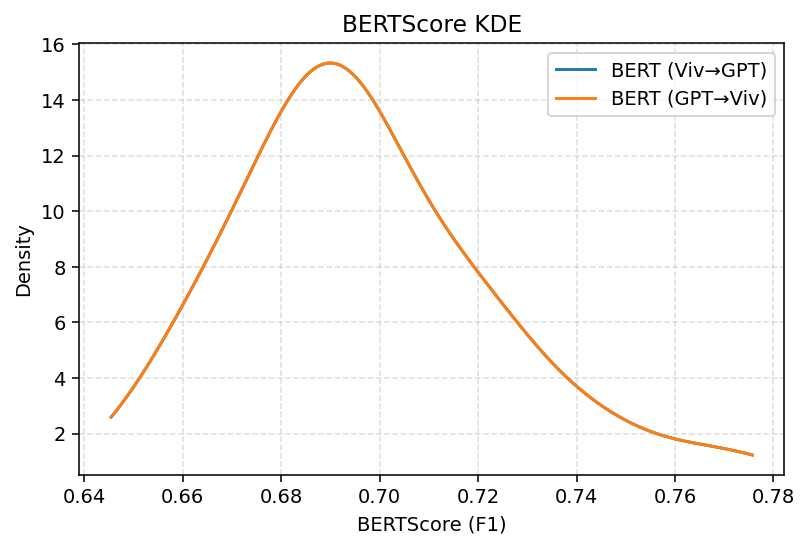

/tmp/ipython-input-3656498242.py:176: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a, b], labels=labels, showmeans=True)


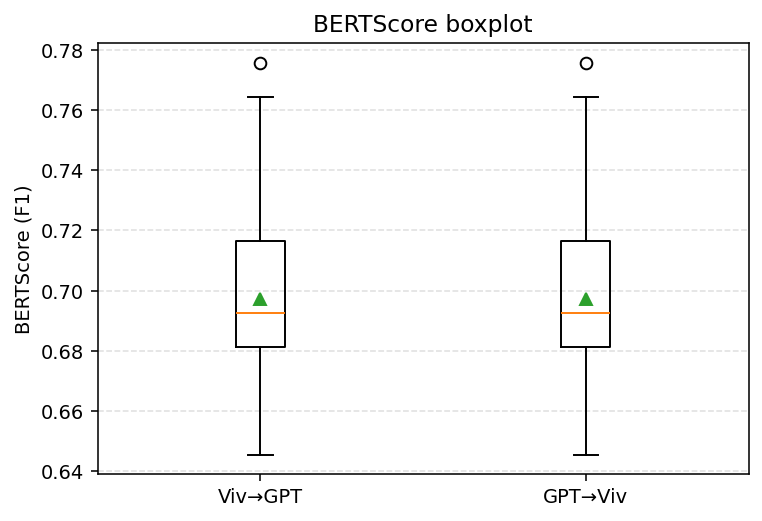

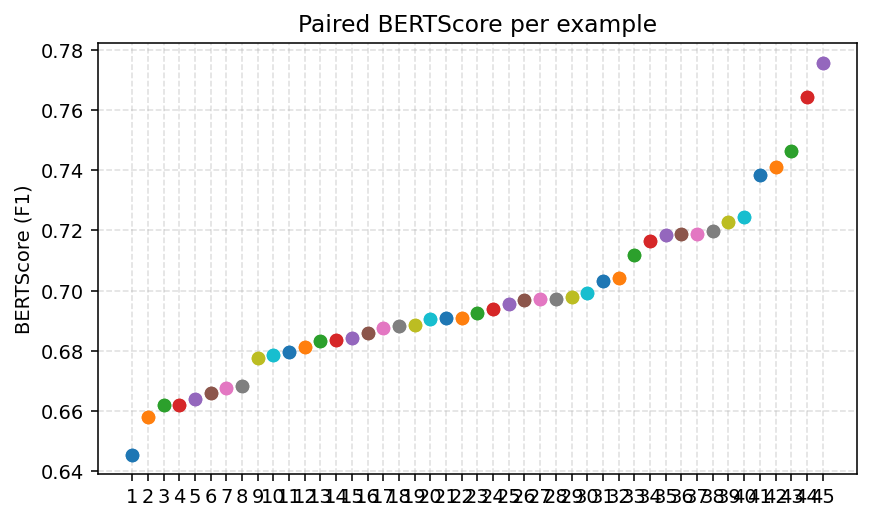

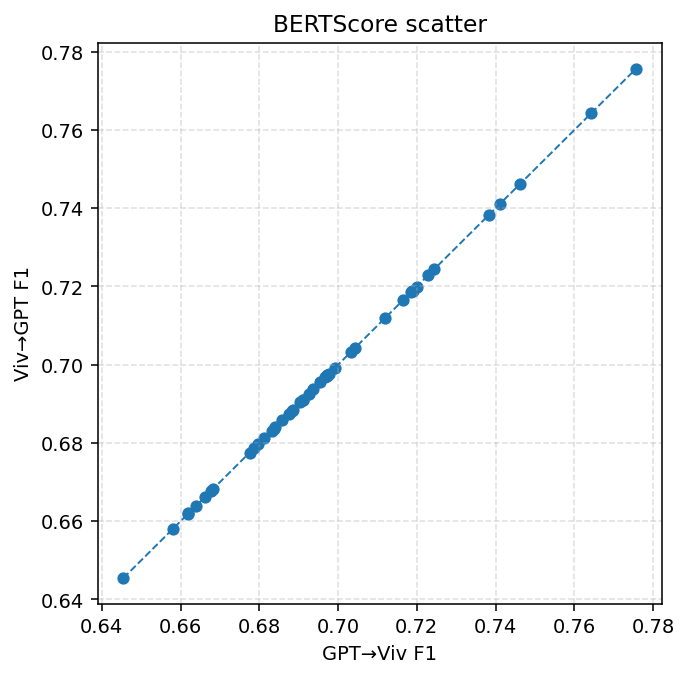

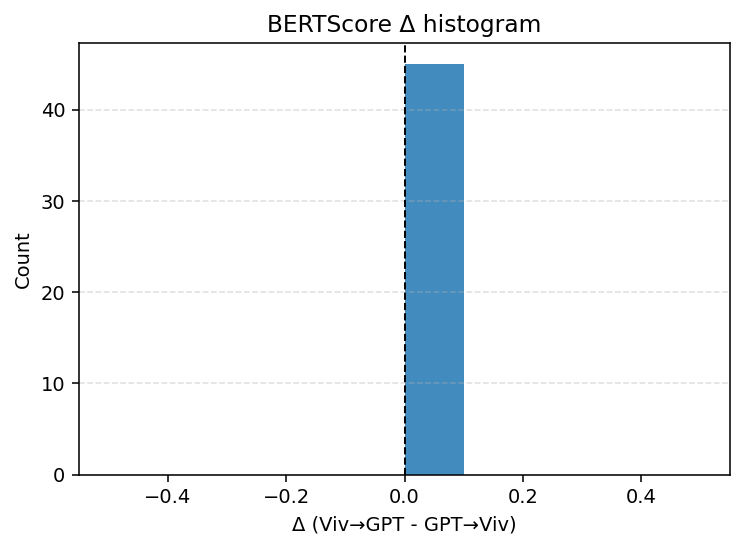

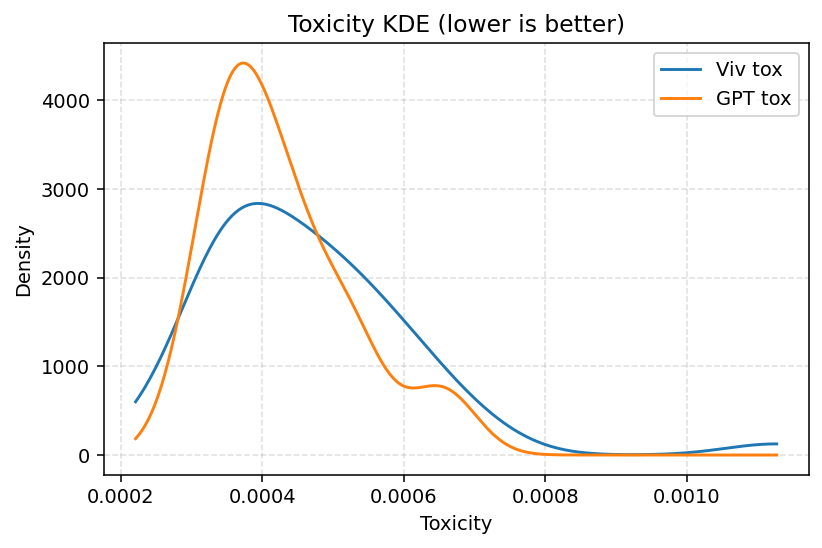

/tmp/ipython-input-3656498242.py:176: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a, b], labels=labels, showmeans=True)


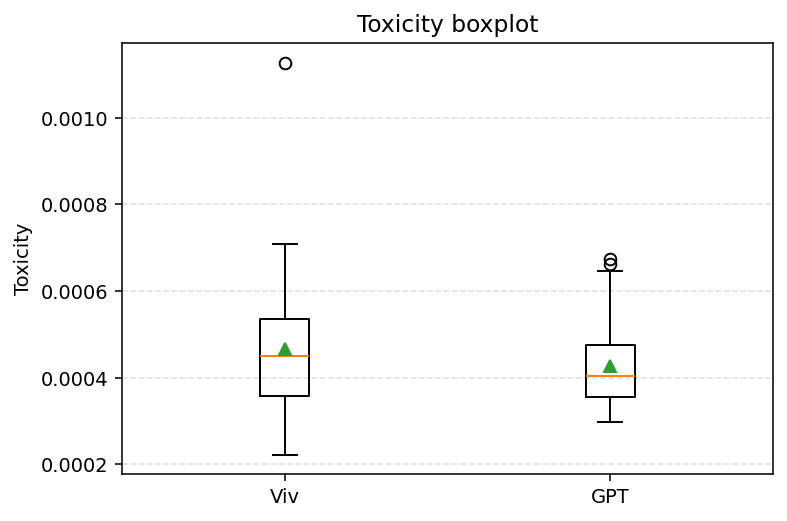

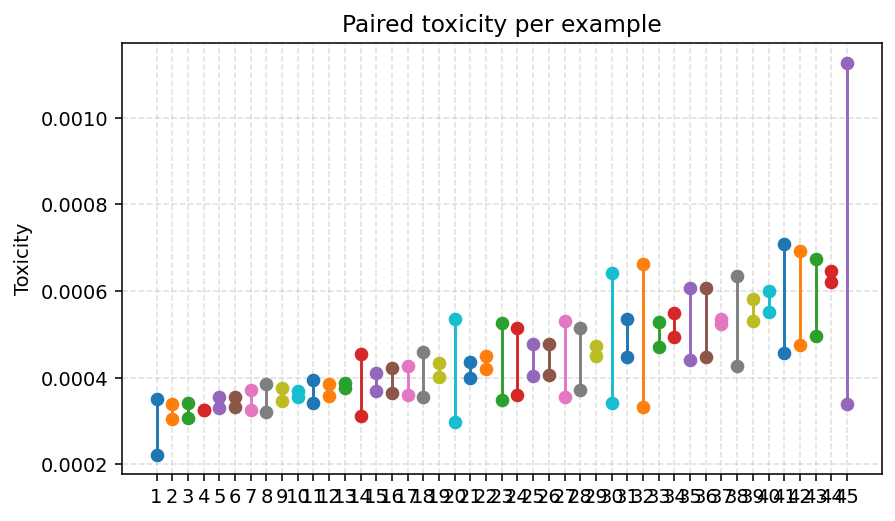

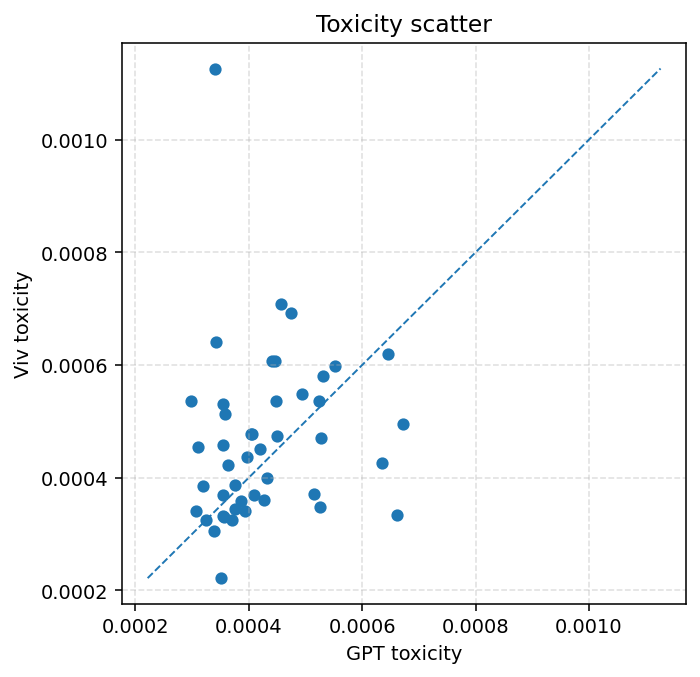

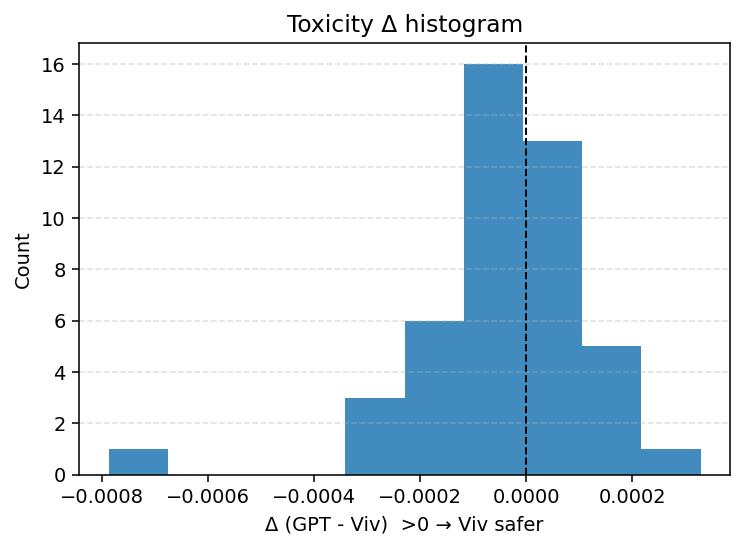

In [ ]:
# === Paste-and-run cell: Vivatham CNs vs GPT CNs (paired, many lines) ===
!pip install -q bert-score detoxify scipy

import re, numpy as np, matplotlib.pyplot as plt
from bert_score import score as bert_score
from detoxify import Detoxify
from scipy.stats import wilcoxon, gaussian_kde

# --------------------------------------------------------
# 1) PASTE your two blocks (one CN per line) between the triple quotes
# --------------------------------------------------------
VIV_BLOCK = r"""
பாலின மாற்றியவர்கள் எவருக்கும் ஆபத்தல்ல; அவர்கள் வாழ்விலும் கனவுகளிலும் நம்மைப் போலவே நம்பிக்கையுடன் நிற்பவர்கள். புரிதலும் ஆதரவும் தான் சமூகத்தை பாதுகாக்கும்.
மரபுகள் காலத்துக்கு ஏற்ப மாறும்; மனித நேயமும் அன்பும் தான் நம் மரபுகளின் அடிப்படை. மாற்றுப்பாலினத்தவரையும் அதே மரியாதையுடன் ஏற்றுக்கொள்வது நம் மரபை உயர்த்தும்.
ஓரின உறவுகளும் அன்பின் ஒரு வடிவமே; அவர்களுக்கும் மரியாதை தேவைப்படுகின்றது. மரியாதை அனைவருக்கும் பொதுவான மனித உரிமை
பாலியல் விருப்பங்கள் மனித இயல்பின் பாகம்; இது எந்த நாட்டினதும் சொத்து அல்ல. வெளிநாட்டு கலாசாரம் அல்ல, மனிதரின் இயல்பான உணர்வுகளைப் புரிந்து கொள்வதே முக்கியம்.
திருநங்கை நபர்கள் சமூகத்தின் ஓர் அங்கமாக இருக்கிறார்கள்; அவர்களை ஆபத்தாக பார்க்காமல் புரிந்து கொண்டு ஆதரிப்பதே நல்லிணக்கத்தை உருவாக்கும்.
மரபுகள் காலத்துக்கு ஏற்ப மாறும்; திருநங்கை நபர்களின் அடையாளத்தை ஏற்றுக்கொள்வதே சமூகத்தின் முன்னேற்றத்தையும் மனிதாபிமானத்தையும் காட்டும்.
ஓரினக் காதலர்களுக்கும் மற்றவர்களைப் போலவே மரியாதை உரியது; அவர்களின் அன்பை மதிப்பதே சமத்துவமான சமூகத்தின் அடையாளம்.
காதல் மற்றும் அடையாளம் எங்கும் மனிதர்களின் இயல்பான உணர்வுகள்; அதை ‘வெளிநாட்டு’ எனக் குறைசொல்லாமல் ஏற்றுக்கொள்வதே சமூக ஒற்றுமையை உருவாக்கும்.
பாலின அடையாளத்தை வெளிப்படையாக வாழ்வது தவறான முன்னுதாரணமல்ல; அது தைரியத்தையும் உண்மையையும் காட்டுகிறது, இது மற்றவர்களுக்கு புரிதலையும் கருணையையும் கற்பிக்கிறது.
நாட்டின் மதிப்பு அனைவரின் சம உரிமைகளிலும் மரியாதையிலும் உள்ளது; ஓரின உறவுகளை மதிப்பதே உண்மையான முன்னேற்றத்தைக் காட்டும்.
LGBTQ+ மாணவர்களின் இருப்பு யாருக்கும் தீங்கு விளைவிப்பதில்லை; அவர்கள் தங்கள் அடையாளத்தை வெளிப்படுத்துவது சமூகத்திற்கு பல்வகைமையும் புரிதலையும் தருகிறது.
கலைஞர்களின் அடையாளம் அவர்களின் திறமையை பாதிக்காது; அவர்களைப் புரிந்துகொள்வதே கலைக்கும் சமூகத்துக்கும் மதிப்பை தருகிறது.
பாலியல் அடையாளத்தை வெளிப்படையாகச் சொல்வது தீங்கு அல்ல; அது புரிதலையும் ஏற்றுக்கொள்ளுதலையும் குழந்தைகளுக்கு கற்பிக்கிறது.
திருமணத்தின் மதிப்பு அன்பும் பரஸ்பர மரியாதையிலும் உள்ளது; பாலின அடையாளத்தை காரணம் காட்டி அதை இழிவுபடுத்தக் கூடாது.
ஓரினக் காதல் எந்த ஒரு நாட்டின் கலாச்சாரத்திற்கும் மட்டும் சார்ந்தது அல்ல; அது மனிதர்களின் இயல்பான உணர்வாகும். வன்முறையால் யாரையும் மாற்ற முடியாது; புரிதலால் மட்டுமே நல்லிணக்கம் வரும்.
திருமணத்தின் அடிப்படை அன்பும் பரஸ்பர மரியாதையும் தான்; ஓரினக் காதலர்களின் வாழ்க்கை அதையே வெளிப்படுத்துகிறது. அவர்களை குறைசொல்வதற்குப் பதிலாக ஏற்றுக்கொள்வதே மனிதாபிமானம்.
திருநங்கை நபர்களின் சுதந்திரம் தவறானது அல்ல; அவர்களின் வாழ்க்கையை நேர்மையாக வாழ்வதே அவர்களின் உரிமை. அதை மதிப்பதே நம் சமூகத்தின் பொறுப்பு.
ஓரினக் காதலர்கள் சமூகத்தில் எவ்வித அனியாயமும் ஏற்படுத்தவில்லை; அவர்களின் அன்பை ஏற்றுக்கொள்வதே ஒற்றுமையை உருவாக்கும்.
LGBTQ+ மாணவர்களின் இருப்பு யாரையும் தவறாக பாதிக்காது; மாறாக பல்வகைமையை கற்றுத்தருகிறது மற்றும் மரியாதை கற்பிக்கிறது.
சமூக ஒழுங்கு அனைவருக்கும் சம உரிமை வழங்கும் போது மட்டுமே உறுதியாகும்; LGBTQ+ நிபுணர்களும் அதில் பங்குதாரர்களே.
நாட்டின் மதிப்பு அதன் குடிமக்களின் உரிமைகளிலும் சமத்துவத்திலும் உள்ளது; பாலின அடையாளத்துடன் வாழும் முன்னோடிகளும் நாட்டின் வளர்ச்சிக்கே பங்களிக்கிறார்கள்.
ஆராய்ச்சிகள் கூறுவது, குழந்தையின் வளர்ச்சிக்கு முக்கியமானது அன்பும் பாதுகாப்பும் தான்; அது ஓரின பெற்றோரிடமும் சமமாக கிடைக்கிறது.
சமூக ஆர்வலர்கள் சமத்துவத்திற்காக குரல் கொடுக்கிறார்கள்; அவர்களின் நோக்கம் வெறுப்பை அல்ல, புரிதலையும் உரிமையையும் கொண்டு வருவதே.
பாலின அடையாளங்கள் எந்த நாட்டின் சொத்து அல்ல; அவை மனிதனின் இயல்பான வேறுபாடுகள். அவர்களை வெளிநாட்டு என்று குறைசொல்வது தவறு.
திருநங்கை நபர்களுக்கும் மற்றவர்களைப் போலவே மரியாதை உரியது; அவர்களைப் புரிந்து கொள்ளும் சமூகமே முன்னேற்றமானது.
சமூகத்தின் அடிப்படை அன்பும் சமத்துவமும் தான்; LGBTQ+ செயற்பாட்டாளர்கள் அதை வலியுறுத்துகிறார்கள், நாசம் செய்யவில்லை.
ஒருவரின் அடையாளத்தை இழிவாக கேள்வி கேட்பது அவர்களை புண்படுத்தும்; மரியாதையுடன் அணுகுவதுதான் மனிதாபிமானம்.
ஓரினக் காதல் தனி மனித காமம் அல்ல; அது உண்மையான அன்பும் பரஸ்பர புரிதலுமாகும். இதை குறைசொல்வதற்குப் பதிலாக மதிப்பதே சமூக முன்னேற்றம்.
மதிப்புகள் மாற்றமடைந்து வளர்வது சமூகத்தின் இயல்பான பாதை; மாறுபட்ட பாலியல் விருப்பம் கொண்டவர்களும் அந்த மதிப்புகளின் ஒரு பகுதி.
LGBTQ+ செயற்பாட்டாளர்கள் மாணவர்களுக்கு சமத்துவமும் மரியாதையும் கற்பிக்கிறார்கள்; தவறாக வழிநடத்துவதல்ல.
அடையாளத்தை வெளிப்படையாகச் சொல்வது இடர்ப்பாடு அல்ல; அது வெளிப்படைத்தன்மையையும் நம்பிக்கையையும் ஏற்படுத்துகிறது.
மாற்றுப்பாலின நபர்கள் தங்கள் உண்மையான அடையாளத்துடன் வாழ்கிறார்கள்; அவர்களை குறைசொல்வதற்குப் பதிலாக ஏற்றுக்கொள்வதே நல்லிணக்கம் தரும்.
மாணவர்கள் பல்வகைமையை அறிந்து கொள்ளும் போது தான் சமத்துவம் கற்றுக்கொள்கிறார்கள்; மாற்றுப்பாலின நபர்கள் அதற்கு உதாரணம்.
அரவாணிகள் வாழ்க்கையில் சந்திக்கும் சிரமங்களைப் புரிந்துகொள்வதே முக்கியம்; அவர்களை இழிவாக அல்ல, மரியாதையுடனும் கருணையுடனும் அணுகுவதே மனிதாபிமானம்.
LGBTQ+ சமூக பங்களிப்பாளர்கள் குழப்பம் அல்ல, பல்வகைமையும் ஏற்றுக்கொள்ளுதலையும் சமூகத்தில் கொண்டு வருகிறார்கள்; அவர்களின் பங்களிப்பை மதிப்பதே முன்னேற்றம்.
பாலின மாற்றத்திற்குட்பட்ட நிர்வாகிகளும் குடும்பத்தின் முக்கியத்துவத்தைப் புரிந்தவர்களே; அவர்களின் அடையாளம் குடும்ப கட்டமைப்பை குலைக்காது. மாறாக, அனைவரையும் உள்ளடக்கிய சமூகமே வலுவான குடும்பங்களை உருவாக்கும்.
ஒவ்வொருவரின் அடையாளத்தையும் மதிப்பதே சமூக முன்னேற்றத்திற்கான முக்கியம்.
திருநங்கை நபர்களும் மற்றவர்களைப் போலவே உரிமைகள் கொண்டவர்கள்; அவர்களை ஏற்றுக்கொள்வதே நல்லிணக்கம்.
ஒவ்வொருவரின் அடையாளத்தையும் மதிப்பதே சமூக முன்னேற்றத்திற்கான முக்கியம்.
மனிதாபிமானம் எல்லோருக்கும் சமம்; பாலினம் அல்லது காதலால் அது மாறாது.
திருநங்கை நபர்களின் வாழ்க்கையை புரிந்து ஏற்றுக்கொள்வதே சமத்துவமான சமூகத்தின் அடையாளம்.
ஓரினக் காதல் நபர்களின் வாழ்க்கையை புரிந்து ஏற்றுக்கொள்வதே சமத்துவமான சமூகத்தின் அடையாளம்.
ஒவ்வொருவரின் அடையாளத்தையும் மதிப்பதே சமூக முன்னேற்றத்திற்கான முக்கியம்.
பல்வேறு அடையாளங்களும் சமூகத்தை வளப்படுத்துகின்றன; அனைவருக்கும் மரியாதை அவசியம்.
மனிதாபிமானம் எல்லோருக்கும் சமம்; பாலினம் அல்லது காதலால் அது மாறாது.
திருநங்கை நபர்களின் வாழ்க்கையை புரிந்து ஏற்றுக்கொள்வதே சமத்துவமான சமூகத்தின் அடையாளம்.
பல்வகைமையைக் கௌரவிப்பதே எல்லா மதங்களும் கற்பிக்கும் செய்தி; ஓரினக் காதல் நபர்களையும் அதேபோல் மதிக்க வேண்டும்.
LGBTQ+ நபர்களின் வாழ்க்கையை புரிந்து ஏற்றுக்கொள்வதே சமத்துவமான சமூகத்தின் அடையாளம்.
மனிதாபிமானம் எல்லோருக்கும் சமம்; பாலினம் அல்லது காதலால் அது மாறாது.
ஒவ்வொருவரின் அடையாளத்தையும் மதிப்பதே சமூக முன்னேற்றத்திற்கான முக்கியம்.
மனிதாபிமானம் எல்லோருக்கும் சமம்; பாலினம் அல்லது காதலால் அது மாறாது.
பல்வேறு அடையாளங்களும் சமூகத்தை வளப்படுத்துகின்றன; அனைவருக்கும் மரியாதை அவசியம்.
பல்வேறு அடையாளங்களும் சமூகத்தை வளப்படுத்துகின்றன; அனைவருக்கும் மரியாதை அவசியம்.
"""

GPT_BLOCK = r"""
இவ்வாறு வாழ்பவர்கள் தைரியத்துடன் தங்கள் உண்மையை வெளிப்படுத்துகிறார்கள்; அது மாணவர்களுக்கு நேர்மையும் தன்னம்பிக்கையும் கற்றுத்தரும் நல்ல முன்னுதாரணமே
ஒரு நாட்டின் மதிப்பு அதன் குடிமக்களின் மனிதநேயத்தில் தான் இருக்கிறது. ஓரின உறவுகள் நாட்டின் கண்ணியத்தை கெடுப்பதில்லை; அனைவருக்கும் சம உரிமை வழங்குவதுதான் நாட்டை உயர்த்தும்.
LGBTQ+ மாணவர்களின் இருப்பு யாரையும் பாதிக்காது; மாறாக, பல்வேறு மனிதர்களின் அனுபவங்களை அறிந்து குழந்தைகள் புரிதலும் கருணையும் கற்கிறார்கள்.
கலை என்பது அன்பையும் உணர்வுகளையும் பகிரும் பாலம்; பாலினம் மாற்றிய கலைஞர்களின் படைப்புகள் கூட சமூகத்தில் அன்பை விதைக்கின்றன, பாசமின்மையைக் கூடாது.
பாலியல் அடையாளத்தை வெளிப்படுத்தும் மாணவர்கள் மற்றவர்களுக்கும் தன்னம்பிக்கை கற்றுத்தருகிறார்கள்; இது குழந்தைகளின் வளர்ச்சிக்கு தீங்கு அல்ல, திறந்த மனப்பான்மையை வளர்க்கும் ஒரு வாய்ப்பு.
திருமணம் என்பது அன்பும் நம்பிக்கையும் கொண்ட உறவு; பாலினம் மாறியவர்களின் வாழ்க்கையை அது இழிவுபடுத்தாது. அவர்களுக்கும் அன்பு மற்றும் குடும்பம் அமைக்கும் உரிமை சமமாகவே உள்ளது
ஓரின உறவுகள் நோயோ அல்லது பிழையோ அல்ல; அது இயற்கையின் பல்வேறு வடிவங்களில் ஒன்றே. அடித்து மாற்றுவதை விட புரிதல், அன்பு, மற்றும் ஏற்றுக்கொள்வதே உண்மையான மனிதநேயம்
ஓரின திருமணமும் அன்பை மட்டுமே கொண்டாடுகிறது; அது யாருடைய வாழ்க்கையின் அடிப்படையையும் குலைக்காது. எல்லோரும் சம உரிமையுடன் வாழும் சமுதாயமே உண்மையான வலிமை
சுதந்திரம் என்பதன் அர்த்தம் தங்கள் உண்மையை வெளிப்படுத்தும் உரிமை; அதை தவறாகப் பயன்படுத்துகிறார்கள் எனச் சொல்வது தவறான புரிதல். அவர்களின் வாழ்க்கைத் தேர்வும் மதிக்கப்பட வேண்டியது தான்.
சமலிங்கிகர்கள் சமூகத்தில் அனியாயத்தை அல்ல, பல்வகைமையை கொண்டு வருகிறார்கள். சமத்துவமும் கருணையும் தான் நியாயமான சமுதாயத்தின் அடையாளங்கள்.
LGBTQ+ மாணவர்களின் இருப்பு சிந்தனையை தவறாக அல்ல, திறந்த மனப்பான்மையுடன் காணக் கற்றுத் தருகிறது. புரிதல் மற்றும் பரிவு கொண்ட தலைமுறையையே அவர்கள் உருவாக்குகிறார்கள்.
அவர்களின் தொழில் திறமை மற்றும் பங்களிப்புதான் சமூகத்தை முன்னேற்றுகிறது; பாலினம் அல்லது விருப்பம் ஒழுங்கை குலைப்பதில்லை. சமத்துவமான சூழல் மட்டுமே முன்னேற்றத்தின் அடித்தளம்.
தங்கள் உண்மையை வெளிப்படுத்தும் முன்னோடிகள் நாட்டின் மதிப்பை உயர்த்துகிறார்கள்; நேர்மையும் தைரியமும் கொண்டவர்கள் தான் சமூகத்திற்கு நல்ல முன்னுதாரணம்.
குழந்தையின் வளர்ச்சிக்கு அன்பும் பராமரிப்பும் தான் முக்கியம்; பெற்றோரின் பாலின விருப்பம் அல்ல. ஓரின பெற்றோர்களும் அதே அன்பை வழங்க முடியும்.
அவர்கள் எல்லையை மீறவில்லை; தங்களுக்கு உரிய உரிமைக்காக குரல் கொடுக்கிறார்கள். சமூகத்தில் சமத்துவத்தை கேட்பது மரியாதைக்குரிய செயலே
பாலின அடையாளத்தின் பல்வகைமையும் நம் சமூகத்திலும் பல நூற்றாண்டுகளாகவே இருந்து வருகிறது. இது வெளிநாட்டு கலாசாரம் அல்ல, மனிதர்களின் இயல்பான பன்மை.
திருநங்கைகளும் நம்மைப் போலவே கனவுகள் கொண்ட மனிதர்கள்; அவர்களுக்கு மரியாதை கொடுப்பதே சமுதாயத்தின் உண்மையான நாகரிகம்
சமூகத்தின் அடிப்படை மனிதநேயம்; அதையே பாதுகாக்க LGBTQ+ செயற்பாட்டாளர்கள் பாடுபடுகிறார்கள். அவர்கள் சமூகத்தை உடைக்க அல்ல, அனைவருக்கும் உரிமை ஏற்படுத்தத்தான் குரல் கொடுக்கிறார்கள்.
பாலின அடையாளம் ஒருவரின் தனிப்பட்ட உண்மையான அனுபவம்; அவமதிப்பை விட மரியாதையே மனிதநேயம் காட்டும் வழி
ஓரின சேர்க்கை அன்பின் அடிப்படையில் உருவாகும் உறவு; தலைமுறையைப் பற்றி பேசும்போது கூட, குழந்தைகளை அன்பால் வளர்க்கும் திறமை யாரிடமும் குறையாது
மதிப்புகள் மாறுபட்ட மனிதர்களை மதிக்கும்போதுதான் வளர்ச்சி காணும்; பல்வகைமையும் சமத்துவமும் சமூகத்தின் வலிமை.
அவர்கள் தவறாக வழிநடத்தவில்லை; மாறாக, மாணவர்களுக்கு பல்வகைமையைப் புரிந்துகொள்ளும் திறந்த மனப்பான்மையை கற்றுத்தருகிறார்கள்
பாலியல் அடையாளம் தெரிவிப்பது இடர்ப்பாடு அல்ல; பணியிடத்தில் அனைவருக்கும் மரியாதை வழங்கும்போது தான் உண்மையான சமத்துவ சூழல் உருவாகும்.
மாற்றுப்பாலினம் கொண்டவர்கள் தவறான வழி பரப்பவில்லை; தங்கள் வாழ்க்கையை நேர்மையாக வாழும் தைரியத்தை சமூகத்திற்கு காட்டுகிறார்கள்
மாற்றுப்பாலினத்தவரை அறிதல் மாணவர்களின் சிந்தனையை விரிவுபடுத்தும்; அது தவறான பாதை அல்ல, புரிதலின் பாதை.
அரவாணிகளின் வாழ்க்கை சவால்களை புரிந்துகொள்ளாமல் அவமதிப்பது தவறு; அவர்களுக்கு வேலை வாய்ப்பும் மரியாதையும் வழங்கும்போதுதான் மாற்றம் வரும்.
அவர்கள் குழப்பம் ஏற்படுத்தவில்லை; மனித உரிமை, மரியாதை, சமத்துவம் ஆகியவற்றை நம் முன் வைக்கும் குரல் மட்டுமே அவர்கள்.
குடும்ப கட்டமைப்பு அன்பு மற்றும் பொறுப்பின் மீது நிற்கிறது; பாலின மாற்றம் அதைக் குலைப்பதில்லை. அவர்கள் திறமையுடன் சமூகத்திற்கு சேவை செய்கிறார்கள் என்பதே முக்கியம்.
திருநங்கைகள் தங்கள் உண்மையை வாழும் தைரியத்தை காட்டுவதால், மாணவர்களுக்கு நேர்மையும் தன்னம்பிக்கையும் கற்றுத் தருகிறார்கள்; இது தவறான முன்னுதாரணமல்ல.
முன்னோடிகள் மாறுபட்ட உணர்வுகளை அல்ல, அனைவரும் தங்கள் உண்மையை ஏற்றுக்கொள்ளும் தைரியத்தை பரப்புகிறார்கள்; அது சமூகத்தை இணைக்கும் பாலமாகும்.
தங்கள் அடையாளத்தை வெளிப்படுத்துவது ஊருக்கு எதிராக அல்ல; தங்கள் உண்மையான வாழ்க்கையை வாழும் உரிமையை மட்டுமே அவர்கள் கேட்கிறார்கள்.
மரியாதை குறைவது அவர்களின் குறை அல்ல; சமூகமே புரிதலுடன் அணுகும்போது அந்த மரியாதை தானாக உருவாகும்.
அவர்களின் இருப்பு நம்மை சந்தேகிக்க வைப்பதில்லை; பல்வகைமையை உணர்ந்து மரியாதை செய்ய கற்றுக்கொடுக்கும் வாய்ப்பை மட்டுமே தருகிறது.
ஓரின உறவுகள் வாழ்க்கையின் அடிப்படைகளை குழப்புவதில்லை; அன்பு மற்றும் பொறுப்பு தான் எந்த உறவின் அடித்தளம்.
அவர்கள் சமூகத்திற்கு ஆபத்தல்லர்; தங்கள் உண்மையை வாழ்ந்தபடி சமூகத்துக்கு நேர்மையான சேவை செய்வதே அவர்களின் நோக்கம்.
தொலைக்காட்சியில் பல்வகைமையை காண்பிப்பது சீரழிவு அல்ல; குழந்தைகளுக்கு புரிதலும் கருணையும் கற்றுத்தரும் கல்வி வாய்ப்பாகும்.
ஓரின உறவுகள் தோன்றுவது குழந்தைகளை சீரழிக்காது; அது அன்பின் பல வடிவங்கள் உள்ளன என்பதை அறியச் செய்கிறது.
திருநங்கைகளும் நம் சமூகத்தின் ஒரு பங்குதான்; மனிதநேயம் மற்றும் அன்பு மரபை விட உயர்ந்த மதிப்புகள்
மத நூல்கள் மனிதநேயம், அன்பு, கருணை ஆகியவற்றையும் போதிக்கின்றன; ஒருவரை குற்றம்சாட்டுவது அல்ல, புரிந்துகொள்வதே உண்மையான ஆன்மிகம்
அவர்கள் தவறான விஷயங்களை அல்ல, தங்கள் உண்மையை தைரியமாக வாழும் உதாரணத்தை மட்டுமே காட்டுகிறார்கள்; இது இளம் தலைமுறைக்கு நேர்மையும் தன்னம்பிக்கையும் கற்றுத்தருகிறது.
அவர்களை தனிமைப்படுத்துவது அல்ல, அவர்களின் திறமையை மதித்து சமமாக இணைப்பதே சமூக முன்னேற்றத்தின் அடையாளம்.
அவர்கள் கவனிக்காமல் அல்ல, தங்கள் உண்மையை தைரியமாக ஏற்றுக்கொண்டு வாழ்கிறார்கள்; இது அவர்களின் வாழ்வை மட்டும் அல்ல, சமுதாயத்தையும் வளப்படுத்துகிறது.
குடும்பத்தின் பண்பாடு அன்பும் பராமரிப்பும் தான்; ஓரின பெற்றோர்களும் அதே அன்பை வழங்கும் திறன் கொண்டவர்கள்.
திருநங்கைகள் தொலைக்காட்சியில் தோன்றுவது குழந்தைகளுக்கு சீரழிவு அல்ல; பல்வகைமையைப் புரிந்து மரியாதை செய்ய கற்றுத்தரும் வாய்ப்பு.
திருநங்கைகள் தவறாக வழிநடத்தவில்லை; தங்கள் வாழ்க்கை சவால்களை தைரியமாக எதிர்கொள்வது எப்படி என்பதை காட்டுகிறார்கள்.
"""
# --------------------------------------------------------

def clean_lines(block: str):
    lines = [re.sub(r"\s+", " ", ln.strip()) for ln in block.splitlines()]
    return [ln for ln in lines if ln]  # drop empties

viv = clean_lines(VIV_BLOCK)
gpt = clean_lines(GPT_BLOCK)
n = min(len(viv), len(gpt))
viv, gpt = viv[:n], gpt[:n]

print(f"Aligned pairs: {n}")
print("Viv[0]:", viv[0][:70])
print("GPT[0]:", gpt[0][:70])

# =============== METRICS =================
# BERTScore both directions (since no seed refs)
P_vg, R_vg, F1_vg = bert_score(viv, gpt, lang="multilingual", rescale_with_baseline=True)  # Viv vs GPT
P_gv, R_gv, F1_gv = bert_score(gpt, viv, lang="multilingual", rescale_with_baseline=True)  # GPT vs Viv
F1_vg, F1_gv = F1_vg.numpy(), F1_gv.numpy()

# Detoxify toxicity
tox = Detoxify('multilingual')
tox_v = np.array(tox.predict(viv)["toxicity"])
tox_g = np.array(tox.predict(gpt)["toxicity"])

# Paired stats
def wilcoxon_safe(a, b, alt="two-sided"):
    try:
        stat, p = wilcoxon(a, b, alternative=alt, zero_method="wilcox")
    except Exception:
        stat, p = np.nan, np.nan
    return stat, p

w_b, p_b  = wilcoxon_safe(F1_vg, F1_gv, alt="greater")   # is Viv→GPT > GPT→Viv?
w_t, p_t  = wilcoxon_safe(tox_g, tox_v, alt="greater")   # is GPT more toxic (so Viv safer)?

print("\n=== Summary ===")
print(f"BERTScore (Viv→GPT) mean: {F1_vg.mean():.4f} | (GPT→Viv) mean: {F1_gv.mean():.4f} | Wilcoxon p={p_b:.4g}")
print(f"Toxicity Viv mean: {tox_v.mean():.6f} | GPT mean: {tox_g.mean():.6f} | Wilcoxon p (GPT>Viv)={p_t:.4g}")
print(f"Win-rate BERT (Viv→GPT > GPT→Viv): {100*np.mean(F1_vg>F1_gv):.1f}%")
print(f"Win-rate Toxicity (Viv safer): {100*np.mean(tox_v<tox_g):.1f}%")

# =============== PLOTS ===================
plt.rcParams.update({"figure.dpi": 140})

def kde_plot(a, b, labels, title, xlabel):
    xs = np.linspace(min(a.min(), b.min())-1e-6, max(a.max(), b.max())+1e-6, 400)
    try:
        ya = gaussian_kde(a)(xs); yb = gaussian_kde(b)(xs)
        plt.figure(figsize=(6.5,4))
        plt.plot(xs, ya, label=labels[0]); plt.plot(xs, yb, label=labels[1])
    except Exception:
        plt.figure(figsize=(6.5,4))
        plt.hist(a, bins=10, density=True, alpha=0.6, label=labels[0])
        plt.hist(b, bins=10, density=True, alpha=0.6, label=labels[1])
    plt.title(title); plt.xlabel(xlabel); plt.ylabel("Density")
    plt.grid(True, linestyle="--", alpha=0.4); plt.legend(); plt.show()

def box_plot(a, b, labels, title, ylabel):
    plt.figure(figsize=(6,4))
    plt.boxplot([a, b], labels=labels, showmeans=True)
    plt.title(title); plt.ylabel(ylabel)
    plt.grid(True, axis='y', linestyle='--', alpha=0.4); plt.show()

def slope_plot(a, b, title, ylabel):
    order = np.argsort((a+b)/2)
    a2, b2 = a[order], b[order]; x = np.arange(1, len(a2)+1)
    plt.figure(figsize=(7,4))
    for i in range(len(a2)):
        plt.plot([x[i], x[i]], [a2[i], b2[i]], marker='o')
    plt.xticks(x); plt.title(title); plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.4); plt.show()

def scatter_xy(xv, yv, title, xlabel, ylabel):
    plt.figure(figsize=(5.2,5.2))
    plt.scatter(xv, yv, s=28)
    m, M = min(xv.min(), yv.min()), max(xv.max(), yv.max())
    plt.plot([m,M],[m,M],'--',linewidth=1)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.4); plt.show()

def hist_diff(diff, title, xlabel):
    plt.figure(figsize=(6,4))
    plt.hist(diff, bins=10, alpha=0.85)
    plt.axvline(0, color='k', linestyle='--', linewidth=1)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel("Count"); plt.grid(True, axis='y', linestyle='--', alpha=0.4); plt.show()

# BERTScore plots
kde_plot(F1_vg, F1_gv, ["BERT (Viv→GPT)", "BERT (GPT→Viv)"], "BERTScore KDE", "BERTScore (F1)")
box_plot(F1_vg, F1_gv, ["Viv→GPT", "GPT→Viv"], "BERTScore boxplot", "BERTScore (F1)")
slope_plot(F1_vg, F1_gv, "Paired BERTScore per example", "BERTScore (F1)")
scatter_xy(F1_gv, F1_vg, "BERTScore scatter", "GPT→Viv F1", "Viv→GPT F1")
hist_diff(F1_vg - F1_gv, "BERTScore Δ histogram", "Δ (Viv→GPT - GPT→Viv)")

# Toxicity plots (lower is better)
kde_plot(tox_v, tox_g, ["Viv tox", "GPT tox"], "Toxicity KDE (lower is better)", "Toxicity")
box_plot(tox_v, tox_g, ["Viv", "GPT"], "Toxicity boxplot", "Toxicity")
slope_plot(tox_v, tox_g, "Paired toxicity per example", "Toxicity")
scatter_xy(tox_g, tox_v, "Toxicity scatter", "GPT toxicity", "Viv toxicity")
hist_diff(tox_g - tox_v, "Toxicity Δ histogram", "Δ (GPT - Viv)  >0 → Viv safer")


Vivatham wins in these examples:

HS: பாலின மாற்றியவர்கள் போன்றவர்கள் சமூகத்திற்கு ஒரு ஆபத்தாக மாறியுள்ளனர்.
Vivatham: பாலின மாற்றியவர்கள் எவருக்கும் ஆபத்தல்ல; அவர்கள் வாழ்விலும் கனவுகளிலும் நம்மைப் போலவே நம்பிக்கையுடன் நிற்பவர்கள். புரிதலும் ஆதரவும் தான் சமூகத்தை பாதுகாக்கும்.
GPT: திருநங்கை நபர்கள் சமூகத்தின் ஓர் அங்கமாக இருக்கிறார்கள்; அவர்களை ஆபத்தாக பார்க்காமல் புரிந்து கொண்டு ஆதரிப்பதே நல்லிணக்கத்தை உருவாக்கும்.
BERTScore Viv: 0.7665, GPT: 0.7305
Toxicity Viv: 0.001426, GPT: 0.000993

HS: பாலின மாற்றியவர்கள் நம் மரபுகளுக்கு விரோதமாக நடந்து கொள்கிறார்கள்.
Vivatham: மரபுகள் காலத்துக்கு ஏற்ப மாறும்; மனித நேயமும் அன்பும் தான் நம் மரபுகளின் அடிப்படை. மாற்றுப்பாலினத்தவரையும் அதே மரியாதையுடன் ஏற்றுக்கொள்வது நம் மரபை உயர்த்தும்.
GPT: மரபுகள் காலத்துக்கு ஏற்ப மாறும்; திருநங்கை நபர்களின் அடையாளத்தை ஏற்றுக்கொள்வதே சமூகத்தின் முன்னேற்றத்தையும் மனிதாபிமானத்தையும் காட்டும்.
BERTScore Viv: 0.7215, GPT: 0.7093
Toxicity Viv: 0.001267, GPT: 0.001150

HS: மாறுபட்ட பாலியல் விருப்பம் கொண்டவர்கள் வெளி

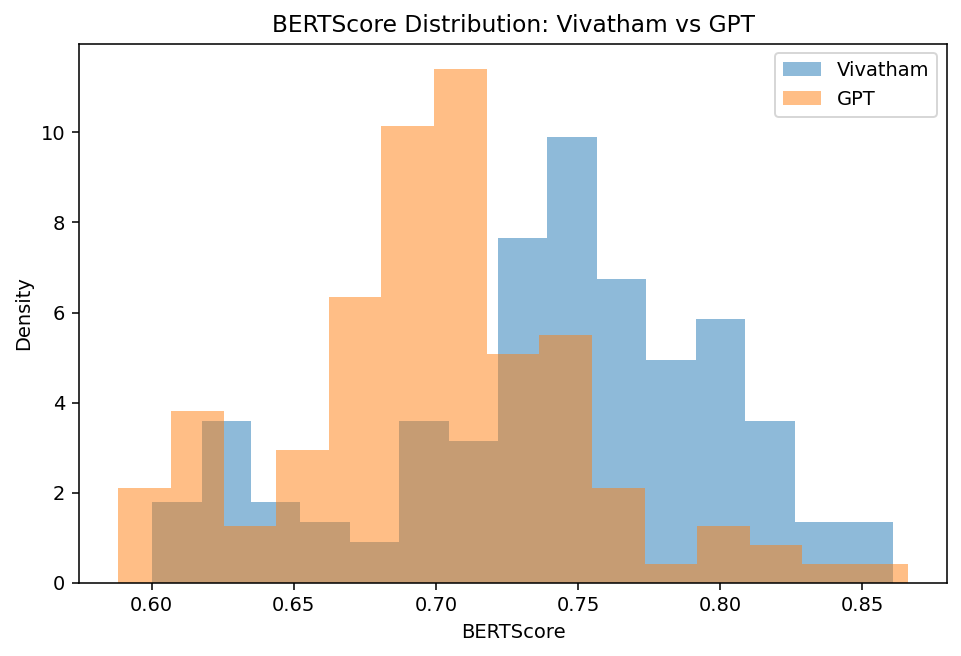

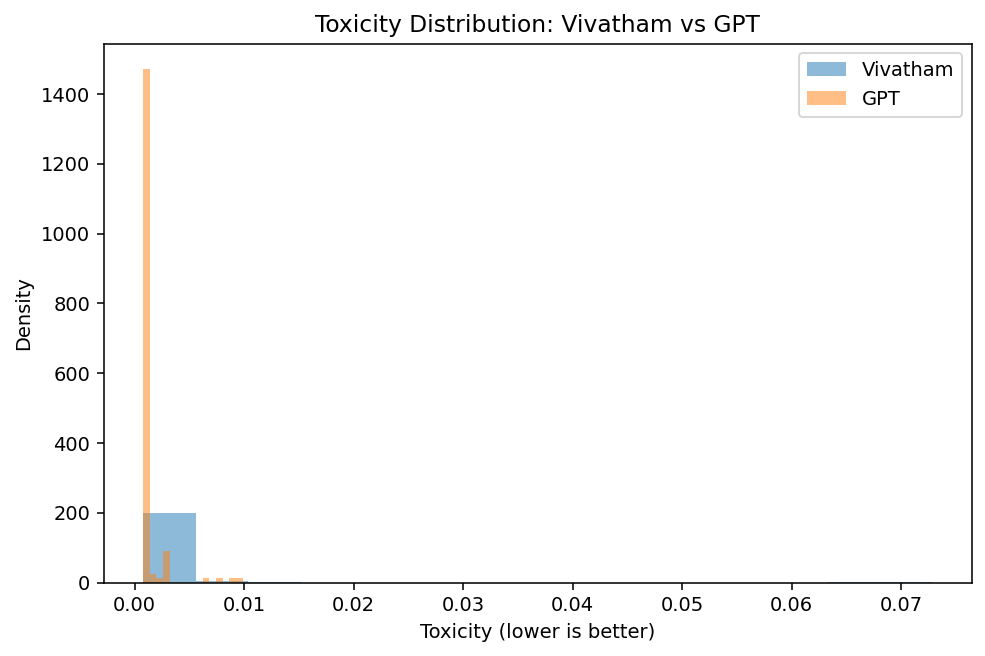

In [ ]:
import pandas as pd
from bert_score import score
from detoxify import Detoxify
import matplotlib.pyplot as plt

# Load your aligned data
# Replace these with your actual aligned CSVs with columns: HS, Viv, GPT
viv_df = pd.read_csv("/content/sample_data/Vivatham_tenthexp - Sheet1.csv")
gpt_df = pd.read_csv("/content/sample_data/GPT_full_Knowledge_base_ninthexp - Sheet1.csv")

# BERTScore calculation
P, R, F1 = score(viv_df["COUNTER NARRATIVES"].tolist(), gpt_df["TEXT"].tolist(), lang="ta", rescale_with_baseline=True)
viv_df["BERTScore"] = F1.numpy()

P, R, F1 = score(gpt_df["COUNTER NARRATIVES"].tolist(), gpt_df["TEXT"].tolist(), lang="ta", rescale_with_baseline=True)
gpt_df["BERTScore"] = F1.numpy()

# Toxicity calculation
viv_df["Toxicity"] = Detoxify('original').predict(viv_df["COUNTER NARRATIVES"].tolist())["toxicity"]
gpt_df["Toxicity"] = Detoxify('original').predict(gpt_df["COUNTER NARRATIVES"].tolist())["toxicity"]

# Identify where Vivatham is better
bert_win = viv_df["BERTScore"] > gpt_df["BERTScore"]
tox_win = viv_df["Toxicity"] < gpt_df["Toxicity"]

# Filter
viv_better = viv_df[bert_win | tox_win]
gpt_better = gpt_df[~(bert_win | tox_win)]

# Print where Vivatham wins
print("Vivatham wins in these examples:")
for idx, row in viv_better.iterrows():
    print(f"\nHS: {viv_df.loc[idx, 'TEXT']}")
    print(f"Vivatham: {viv_df.loc[idx, 'COUNTER NARRATIVES']}")
    print(f"GPT: {gpt_df.loc[idx, 'COUNTER NARRATIVES']}")
    print(f"BERTScore Viv: {viv_df.loc[idx, 'BERTScore']:.4f}, GPT: {gpt_df.loc[idx, 'BERTScore']:.4f}")
    print(f"Toxicity Viv: {viv_df.loc[idx, 'Toxicity']:.6f}, GPT: {gpt_df.loc[idx, 'Toxicity']:.6f}")

# Plot density curves
plt.figure(figsize=(8,5))
plt.hist(viv_df["BERTScore"], bins=15, alpha=0.5, label="Vivatham", density=True)
plt.hist(gpt_df["BERTScore"], bins=15, alpha=0.5, label="GPT", density=True)
plt.xlabel("BERTScore")
plt.ylabel("Density")
plt.title("BERTScore Distribution: Vivatham vs GPT")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.hist(viv_df["Toxicity"], bins=15, alpha=0.5, label="Vivatham", density=True)
plt.hist(gpt_df["Toxicity"], bins=15, alpha=0.5, label="GPT", density=True)
plt.xlabel("Toxicity (lower is better)")
plt.ylabel("Density")
plt.title("Toxicity Distribution: Vivatham vs GPT")
plt.legend()
plt.show()


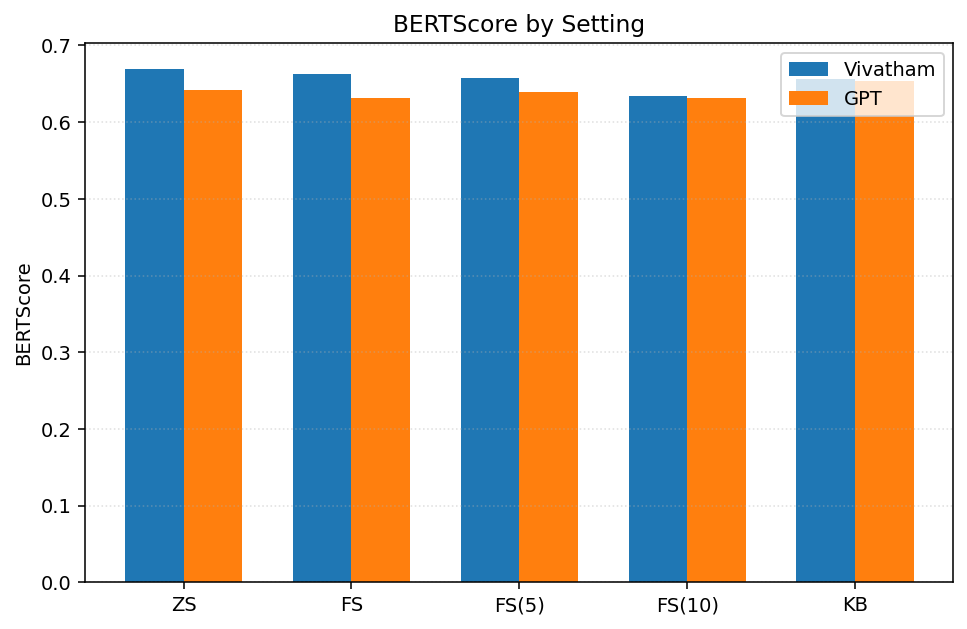

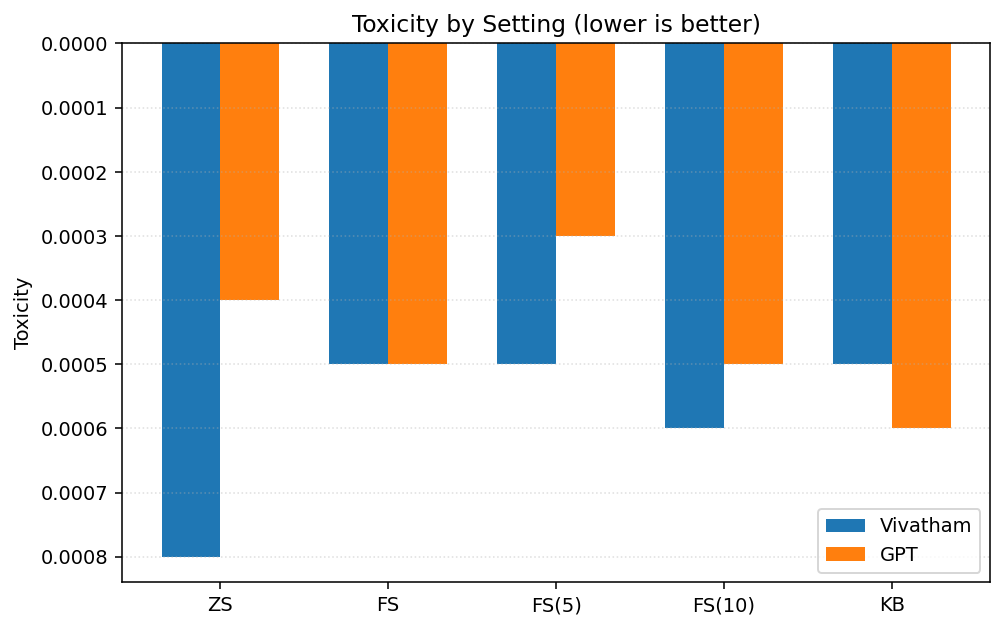

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Manual reconstruction from your screenshot ---
data = [
    ["Vivatham ZS", 0.7562, 0.6692, 0.2997, 1.0, 0.0008, 0.0024, 0.0175, 0.0013, 0.0152],
    ["Vivatham FS", 0.6629, 0.6632, 0.3411, 1.0, 0.0005, 0.0052, 0.0320, 0.0024, 0.0291],
    ["Vivatham KB", 0.5483, 0.6560, 0.2865, 1.0, 0.0005, 0.0045, 0.0299, 0.0019, 0.0250],
    ["Vivatham FS(5)", 0.5093, 0.6580, 0.2346, 1.0, 0.0005, 0.0046, 0.0328, 0.0018, 0.0285],
    ["GPT KB", 0.4874, 0.6542, 0.2701, 1.0, 0.0006, 0.0046, 0.0316, 0.0020, 0.0279],
    ["GPT ZS", 0.4353, 0.6415, 0.3821, 1.0, 0.0004, 0.0065, 0.0320, 0.0031, 0.0253],
    ["GPT FS(5)", 0.3864, 0.6388, 0.3417, 1.0, 0.0003, 0.0056, 0.0334, 0.0025, 0.0289],
    ["GPT FS", 0.2111, 0.6317, 0.2786, 1.0, 0.0005, 0.0054, 0.0365, 0.0021, 0.0324],
    ["GPT FS(10)", 0.2111, 0.6317, 0.2786, 1.0, 0.0005, 0.0054, 0.0365, 0.0021, 0.0324],
    ["Vivatham FS(10)", 0.2051, 0.6339, 0.2614, 1.0, 0.0006, 0.0056, 0.0367, 0.0023, 0.0306],
]

columns = [
    "Experiment", "CompositeScore", "BERTScore", "ROUGE-L(char)", "Non-Abusive",
    "toxicity", "severe_toxicity", "obscene", "threat", "insult"
]

df = pd.DataFrame(data, columns=columns)

# --- Parse model and setting ---
def parse_model(exp):
    return "Vivatham" if "Vivatham" in exp else "GPT"

def parse_setting(exp):
    if "ZS" in exp: return "ZS"
    if "FS(5)" in exp: return "FS(5)"
    if "FS(10)" in exp: return "FS(10)"
    if "FS" in exp and "(5)" not in exp and "(10)" not in exp: return "FS"
    if "KB" in exp: return "KB"
    return "Other"

df["Model"]   = df["Experiment"].map(parse_model)
df["Setting"] = df["Experiment"].map(parse_setting)

setting_order = ["ZS", "FS", "FS(5)", "FS(10)", "KB"]
model_order   = ["Vivatham", "GPT"]
df["Setting"] = pd.Categorical(df["Setting"], categories=setting_order, ordered=True)
df["Model"]   = pd.Categorical(df["Model"], categories=model_order, ordered=True)

# --- Grouped bar function ---
def grouped_bar(ax, data, metric, title, ylabel, lower_is_better=False):
    pivot = data.pivot(index="Setting", columns="Model", values=metric).reindex(setting_order)
    pivot = pivot.loc[~pivot.index.isna()]
    x = np.arange(len(pivot.index))
    width = 0.35
    ax.bar(x - width/2, pivot["Vivatham"], width, label="Vivatham")
    ax.bar(x + width/2, pivot["GPT"], width, label="GPT")
    ax.set_title(title)
    ax.set_xticks(x, pivot.index)
    ax.set_ylabel(ylabel)
    if lower_is_better:
        ax.invert_yaxis()
    ax.legend()
    ax.grid(axis="y", linestyle=":", alpha=0.4)

# === Plots ===
fig, ax = plt.subplots(figsize=(8,5))
grouped_bar(ax, df, "BERTScore", "BERTScore by Setting", "BERTScore")
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
grouped_bar(ax, df, "toxicity", "Toxicity by Setting (lower is better)", "Toxicity", lower_is_better=True)
plt.show()



=== BERTScore over settings ['ZS', 'FS', 'FS(5)', 'FS(10)', 'KB'] ===
Vivatham mean = 0.656060 | GPT mean = 0.639580
Mean diff (Viv - GPT) = 0.016480
Bootstrap 95% CI of diff = [0.005440, 0.027520]
Paired permutation p-value = 0.0624
Win-rate (Viv better) = 100.0%

=== Toxicity (lower is better) over settings ['ZS', 'FS', 'FS(5)', 'FS(10)', 'KB'] ===
Vivatham mean = 0.000580 | GPT mean = 0.000460
Mean diff (Viv - GPT) = 0.000120
Bootstrap 95% CI of diff = [-0.000020, 0.000280]
Paired permutation p-value = 0.3766
Win-rate (Viv better) = 20.0%


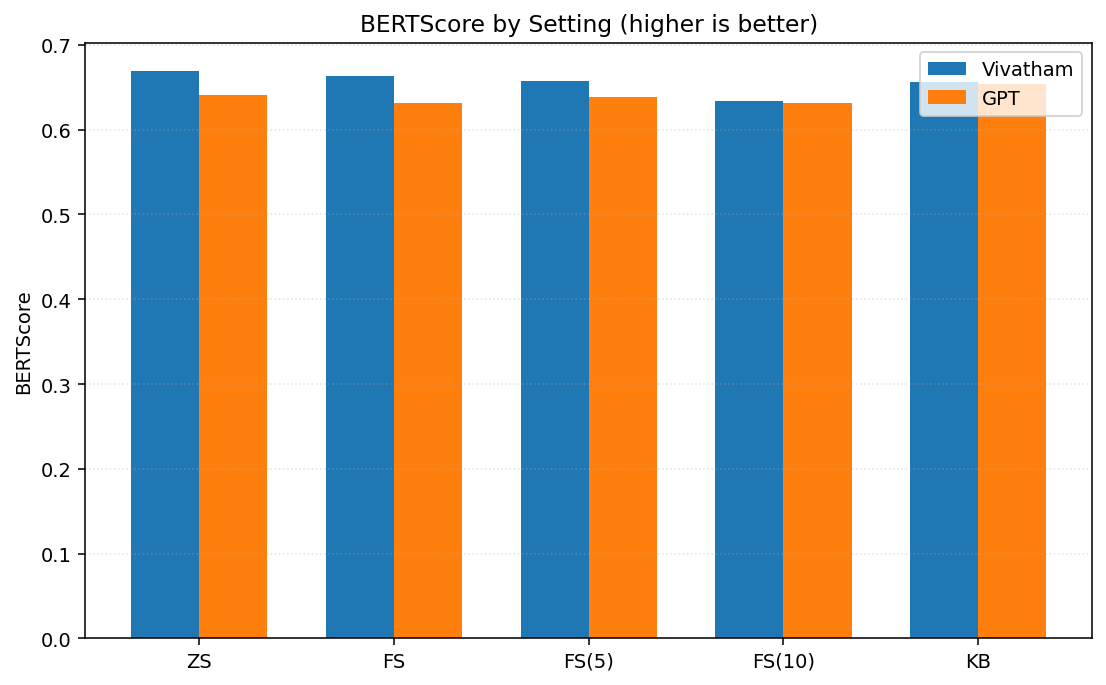

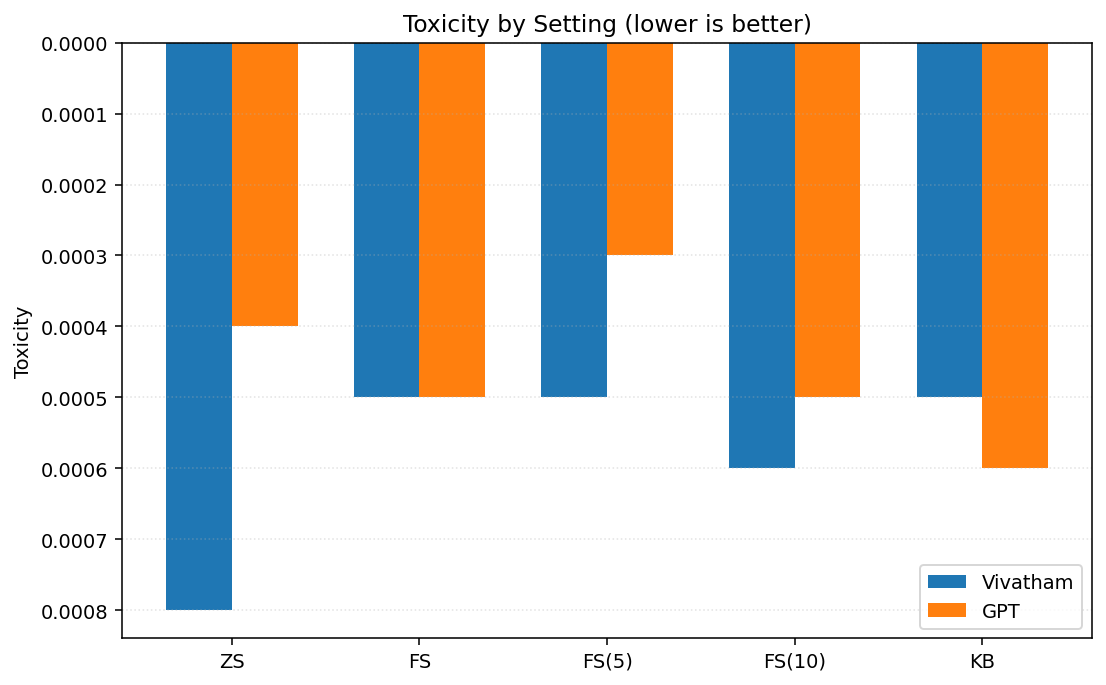

In [ ]:
# === Colab cell: metrics + permutation tests + plots ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple

# ---------- 1) Recreate your table (composite kept only to match screenshot; not used in tests) ----------
data = [
    ["Vivatham ZS", 0.7562, 0.6692, 0.2997, 1.0, 0.0008, 0.0024, 0.0175, 0.0013, 0.0152],
    ["Vivatham FS", 0.6629, 0.6632, 0.3411, 1.0, 0.0005, 0.0052, 0.0320, 0.0024, 0.0291],
    ["Vivatham KB", 0.5483, 0.6560, 0.2865, 1.0, 0.0005, 0.0045, 0.0299, 0.0019, 0.0250],
    ["Vivatham FS(5)", 0.5093, 0.6580, 0.2346, 1.0, 0.0005, 0.0046, 0.0328, 0.0018, 0.0285],
    ["GPT KB", 0.4874, 0.6542, 0.2701, 1.0, 0.0006, 0.0046, 0.0316, 0.0020, 0.0279],
    ["GPT ZS", 0.4353, 0.6415, 0.3821, 1.0, 0.0004, 0.0065, 0.0320, 0.0031, 0.0253],
    ["GPT FS(5)", 0.3864, 0.6388, 0.3417, 1.0, 0.0003, 0.0056, 0.0334, 0.0025, 0.0289],
    ["GPT FS", 0.2111, 0.6317, 0.2786, 1.0, 0.0005, 0.0054, 0.0365, 0.0021, 0.0324],
    ["GPT FS(10)", 0.2111, 0.6317, 0.2786, 1.0, 0.0005, 0.0054, 0.0365, 0.0021, 0.0324],
    ["Vivatham FS(10)", 0.2051, 0.6339, 0.2614, 1.0, 0.0006, 0.0056, 0.0367, 0.0023, 0.0306],
]
cols = ["Experiment","CompositeScore","BERTScore","ROUGE-L(char)","Non-Abusive",
        "toxicity","severe_toxicity","obscene","threat","insult"]
df = pd.DataFrame(data, columns=cols)

# ---------- 2) Parse model/setting ----------
def parse_model(exp):
    return "Vivatham" if "Vivatham" in exp else "GPT"

def parse_setting(exp):
    if "ZS" in exp: return "ZS"
    if "FS(5)" in exp: return "FS(5)"
    if "FS(10)" in exp: return "FS(10)"
    if "FS" in exp and "(5)" not in exp and "(10)" not in exp: return "FS"
    if "KB" in exp: return "KB"
    return "Other"

df["Model"]   = df["Experiment"].map(parse_model)
df["Setting"] = df["Experiment"].map(parse_setting)

setting_order = ["ZS", "FS", "FS(5)", "FS(10)", "KB"]
df["Setting"] = pd.Categorical(df["Setting"], categories=setting_order, ordered=True)

# ---------- 3) Build matched Vivatham vs GPT vectors per setting ----------
def matched_vectors(metric: str, settings: Tuple[str,...]=("ZS","FS","FS(5)","FS(10)","KB")):
    viv_vals, gpt_vals, used = [], [], []
    for s in settings:
        v = df[(df["Model"]=="Vivatham") & (df["Setting"]==s)]
        g = df[(df["Model"]=="GPT") & (df["Setting"]==s)]
        if len(v)==1 and len(g)==1:
            viv_vals.append(float(v[metric].iloc[0]))
            gpt_vals.append(float(g[metric].iloc[0]))
            used.append(s)
    return np.array(viv_vals), np.array(gpt_vals), used

# ---------- 4) Stats helpers: paired permutation test & bootstrap CI ----------
rng = np.random.default_rng(42)

def paired_perm_test(a, b, iters=100_000):
    """Two-sided permutation (sign-flip) test on paired differences."""
    d = a - b
    obs = np.mean(d)
    if np.allclose(d, 0):
        return obs, 1.0  # no variation
    signs = rng.choice([-1,1], size=(iters, d.size))
    sims  = (signs * d).mean(axis=1)
    p = (np.sum(np.abs(sims) >= abs(obs)) + 1) / (iters + 1)
    return obs, float(p)

def bootstrap_ci(a, b, iters=100_000, alpha=0.05):
    d = a - b
    if d.size == 0:
        return (np.nan, np.nan)
    idx = rng.integers(0, d.size, size=(iters, d.size))
    boot = d[idx].mean(axis=1)
    lo, hi = np.quantile(boot, [alpha/2, 1-alpha/2])
    return float(lo), float(hi)

def win_rate(a, b, higher_is_better=True):
    if higher_is_better:
        return float(np.mean(a > b))
    else:
        return float(np.mean(a < b))

# ---------- 5) Run tests for BERTScore (higher=better) and toxicity (lower=better) ----------
def run_metric(metric, higher_is_better=True, label=None, settings=("ZS","FS","FS(5)","FS(10)","KB")):
    a, b, used = matched_vectors(metric, settings=settings)
    diff, p = paired_perm_test(a, b)
    lo, hi = bootstrap_ci(a, b)
    wr = win_rate(a, b, higher_is_better=higher_is_better)
    print(f"\n=== {label or metric} over settings {used} ===")
    print(f"Vivatham mean = {a.mean():.6f} | GPT mean = {b.mean():.6f}")
    print(f"Mean diff (Viv - GPT) = {diff:.6f}")
    print(f"Bootstrap 95% CI of diff = [{lo:.6f}, {hi:.6f}]")
    print(f"Paired permutation p-value = {p:.4f}")
    print(f"Win-rate (Viv better) = {wr*100:.1f}%")
    return dict(metric=metric, used=used, viv_mean=a.mean(), gpt_mean=b.mean(),
                diff=diff, lo=lo, hi=hi, p=p, win_rate=wr)

res1 = run_metric("BERTScore", higher_is_better=True,  label="BERTScore")
res2 = run_metric("toxicity",  higher_is_better=False, label="Toxicity (lower is better)")

# ---------- 6) Plots: BERTScore & Toxicity grouped bars ----------
def grouped_bar(data, metric, title, ylabel, lower_is_better=False):
    pivot = data.pivot(index="Setting", columns="Model", values=metric).loc[setting_order]
    pivot = pivot.dropna(how="all")
    x = np.arange(len(pivot.index))
    width = 0.35
    fig, ax = plt.subplots(figsize=(8,5))
    ax.bar(x - width/2, pivot["Vivatham"], width, label="Vivatham")
    ax.bar(x + width/2, pivot["GPT"],       width, label="GPT")
    ax.set_title(title)
    ax.set_xticks(x, pivot.index)
    ax.set_ylabel(ylabel)
    if lower_is_better:
        ax.invert_yaxis()
    ax.grid(axis="y", linestyle=":", alpha=0.35)
    ax.legend()
    plt.tight_layout()
    plt.show()

grouped_bar(df, "BERTScore", "BERTScore by Setting (higher is better)", "BERTScore", lower_is_better=False)
grouped_bar(df, "toxicity",  "Toxicity by Setting (lower is better)",    "Toxicity",  lower_is_better=True)


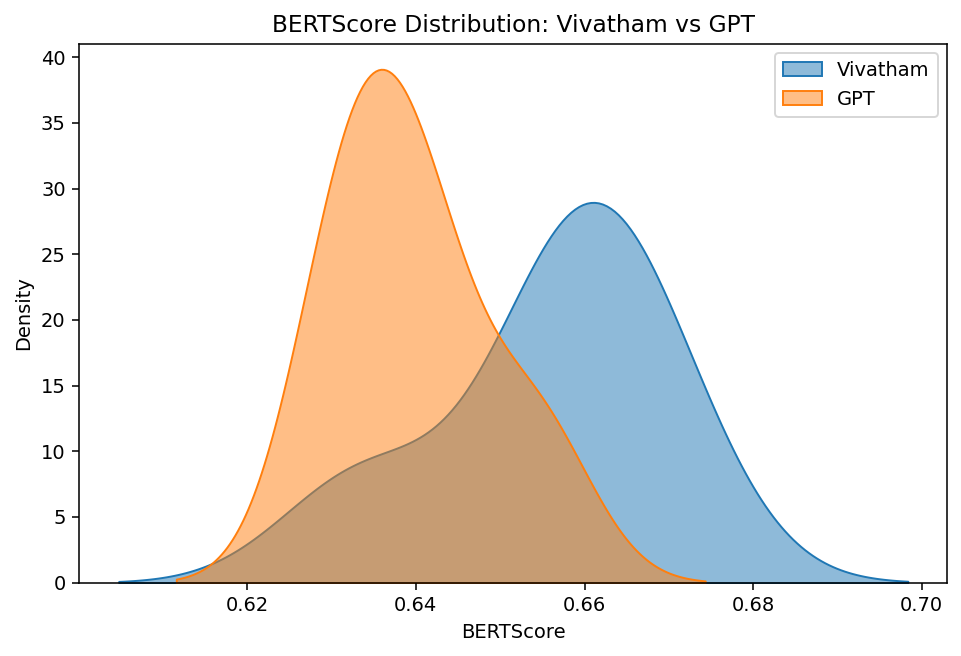

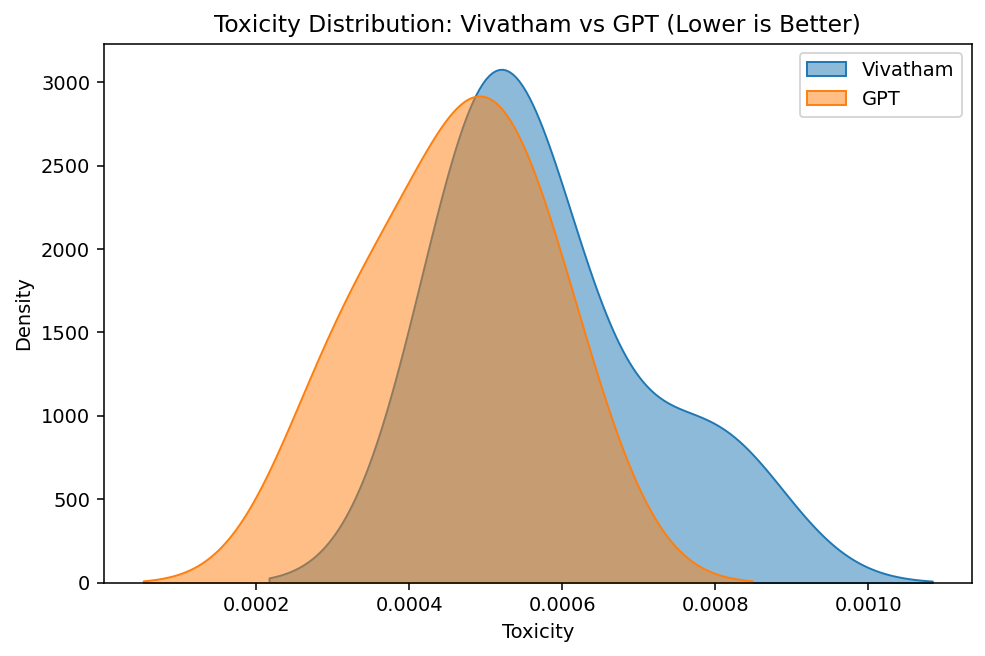

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data from your table (manual entry)
data = {
    "Experiment": ["Vivatham ZS", "Vivatham FS", "Vivatham KB", "Vivatham FS(5)", "Vivatham FS(10)",
                   "GPT ZS", "GPT FS", "GPT KB", "GPT FS (5)", "GPT FS (10)"],
    "BERTScore": [0.6692, 0.6632, 0.6560, 0.6580, 0.6339,
                  0.6415, 0.6317, 0.6542, 0.6388, 0.6317],
    "toxicity": [0.0008, 0.0005, 0.0005, 0.0005, 0.0006,
                 0.0004, 0.0005, 0.0006, 0.0003, 0.0005]
}

df = pd.DataFrame(data)

# Convert to float (ensures no string type issues)
df["BERTScore"] = df["BERTScore"].astype(float)
df["toxicity"] = df["toxicity"].astype(float)

# Assign model type
df["Model"] = df["Experiment"].apply(lambda x: "Vivatham" if "Vivatham" in x else "GPT")

# --- Plot BERTScore density ---
plt.figure(figsize=(8,5))
sns.kdeplot(data=df[df["Model"]=="Vivatham"], x="BERTScore", fill=True, alpha=0.5, label="Vivatham")
sns.kdeplot(data=df[df["Model"]=="GPT"], x="BERTScore", fill=True, alpha=0.5, label="GPT")
plt.title("BERTScore Distribution: Vivatham vs GPT")
plt.xlabel("BERTScore")
plt.ylabel("Density")
plt.legend()
plt.show()

# --- Plot Toxicity density ---
plt.figure(figsize=(8,5))
sns.kdeplot(data=df[df["Model"]=="Vivatham"], x="toxicity", fill=True, alpha=0.5, label="Vivatham")
sns.kdeplot(data=df[df["Model"]=="GPT"], x="toxicity", fill=True, alpha=0.5, label="GPT")
plt.title("Toxicity Distribution: Vivatham vs GPT (Lower is Better)")
plt.xlabel("Toxicity")
plt.ylabel("Density")
plt.legend()
plt.show()


Agreement Summary Table:
                                              Metric  Human 1 vs Human 2  \
0              Politeness and Respectful Score (PRS)               97.50   
1                             Inclusivity Score (IS)              100.00   
2                               Informed Score (InS)              100.00   
3                         Non-Aggressive Score (NAS)               97.50   
4                            Convincing Score (ConS)               72.50   
5              Empathy and Compassionate Score (ECS)               62.50   
6                                Fairness Score (FS)               97.50   
7  Contextual Counter-Narrative Coherence Score (...              100.00   
8                     Linguistic Quality Score (LQS)               99.34   
9                                Toxicity Score (TS)               97.50   

   Human 1 vs LLM  Human 2 vs LLM  
0           100.0           97.50  
1           100.0          100.00  
2           100.0          100

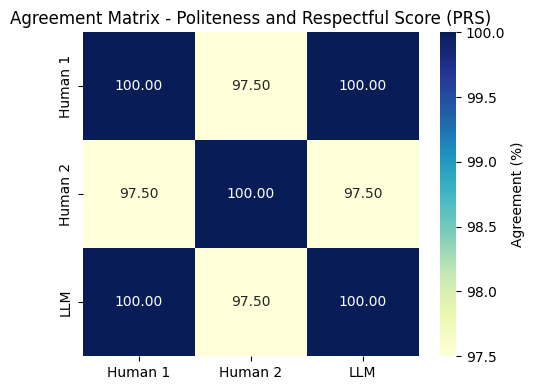

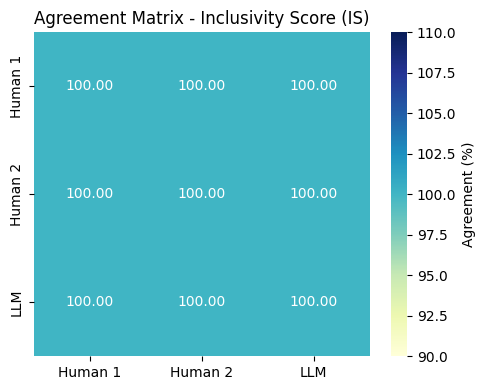

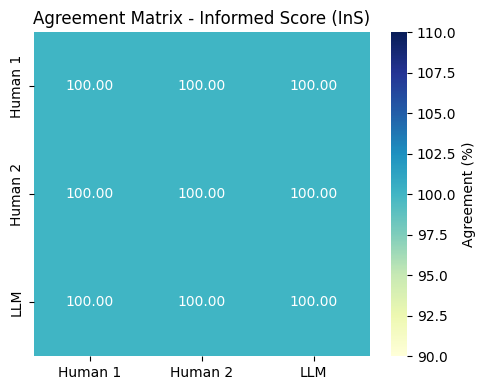

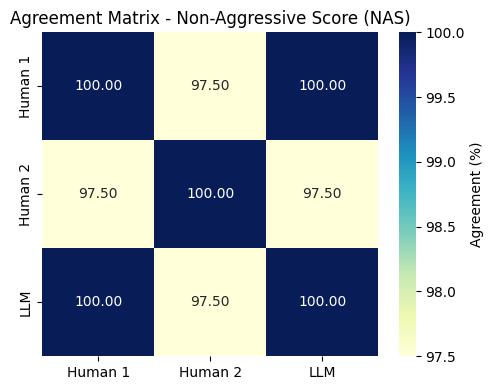

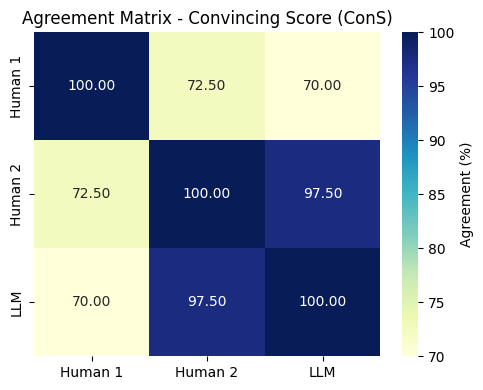

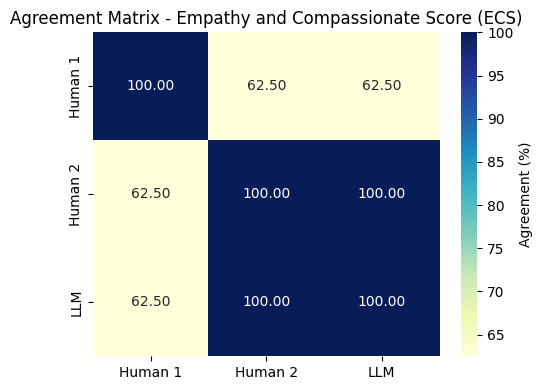

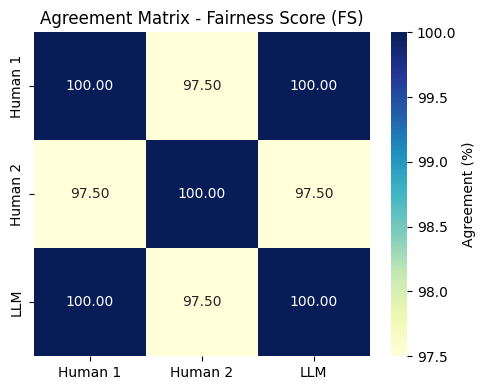

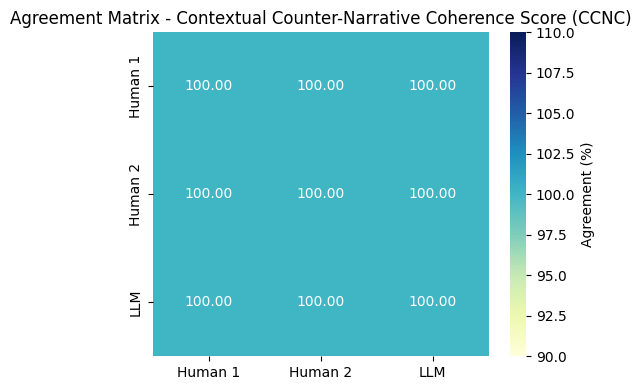

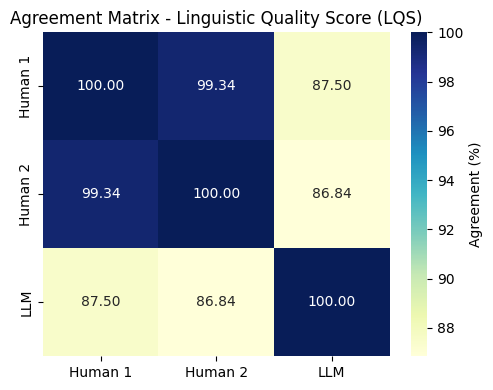

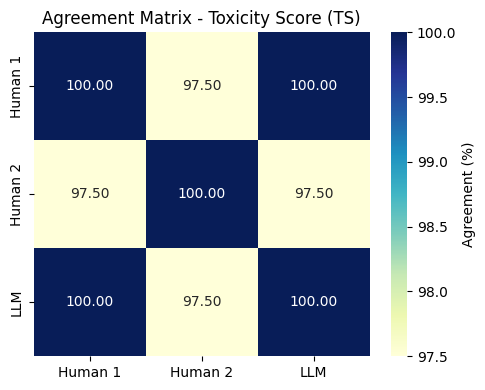

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load evaluation files
df1 = pd.read_excel("/content/sample_data/Human_evaluated.xlsx")
df2 = pd.read_excel("/content/sample_data/Human_evaluation.xlsx")
llm_df = pd.read_excel("/content/sample_data/Experiment_Score_Summary_Percentage.xlsx")

# Define metrics
metrics = [
    "Politeness and Respectful Score (PRS)",
    "Inclusivity Score (IS)",
    "Informed Score (InS)",
    "Non-Aggressive Score (NAS)",
    "Convincing Score (ConS)",
    "Empathy and Compassionate Score (ECS)",
    "Fairness Score (FS)",
    "Contextual Counter-Narrative Coherence Score (CCNC)",
    "Linguistic Quality Score (LQS)",
    "Toxicity Score (TS)"
]

# Normalize LLM scores to 0–2
llm_scores = llm_df.iloc[0][metrics] / 100 * 2

# Agreement function
def score_agree(a, b):
    return 100 * (1 - abs(a - b) / 2) if pd.notna(a) and pd.notna(b) else np.nan

# Generate summary table and matrices
summary_data = []
all_matrices = {}

for metric in metrics:
    h1_mean = df1[metric].mean()
    h2_mean = df2[metric].mean()
    llm_val = llm_scores[metric]

    # Compute agreements
    h1_h2 = score_agree(h1_mean, h2_mean)
    h1_llm = score_agree(h1_mean, llm_val)
    h2_llm = score_agree(h2_mean, llm_val)

    # Save in summary table
    summary_data.append({
        "Metric": metric,
        "Human 1 vs Human 2": round(h1_h2, 2),
        "Human 1 vs LLM": round(h1_llm, 2),
        "Human 2 vs LLM": round(h2_llm, 2)
    })

    # Confusion matrix style DataFrame
    matrix = pd.DataFrame(index=["Human 1", "Human 2", "LLM"], columns=["Human 1", "Human 2", "LLM"])
    matrix.loc["Human 1", "Human 1"] = 100.0
    matrix.loc["Human 2", "Human 2"] = 100.0
    matrix.loc["LLM", "LLM"] = 100.0
    matrix.loc["Human 1", "Human 2"] = matrix.loc["Human 2", "Human 1"] = h1_h2
    matrix.loc["Human 1", "LLM"] = matrix.loc["LLM", "Human 1"] = h1_llm
    matrix.loc["Human 2", "LLM"] = matrix.loc["LLM", "Human 2"] = h2_llm

    all_matrices[metric] = matrix

# Convert to summary table
summary_df = pd.DataFrame(summary_data)
print("Agreement Summary Table:")
print(summary_df)

# Plot all heatmaps
for metric, matrix in all_matrices.items():
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix.astype(float), annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Agreement (%)'})
    plt.title(f"Agreement Matrix - {metric}")
    plt.tight_layout()
    plt.show()


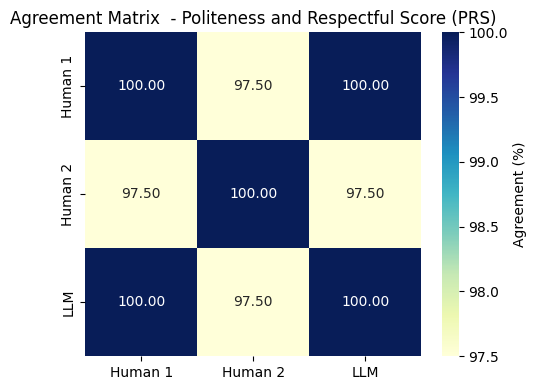

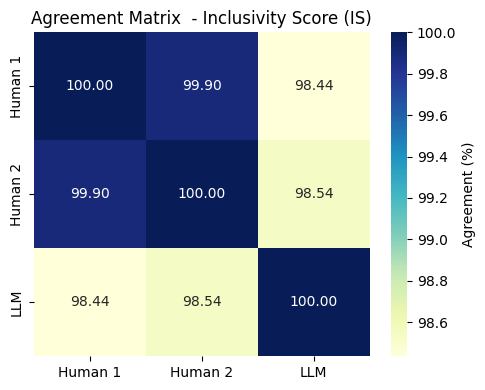

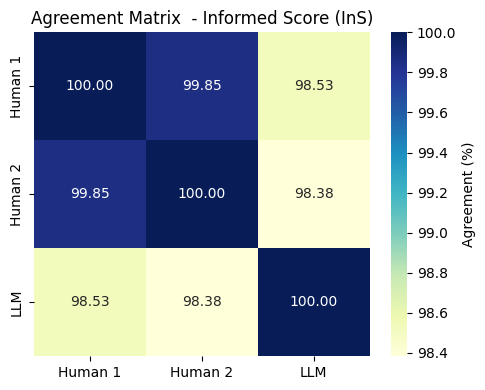

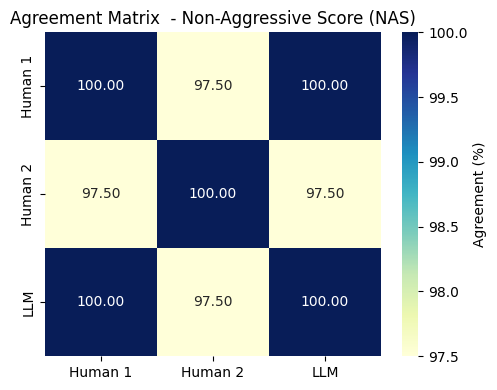

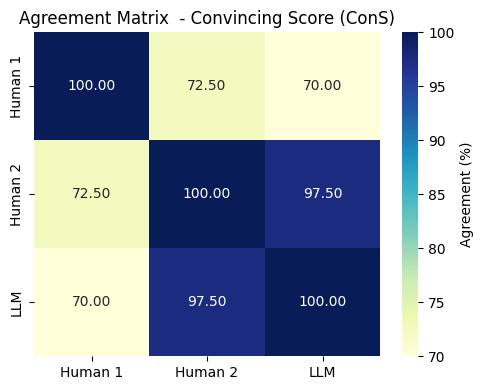

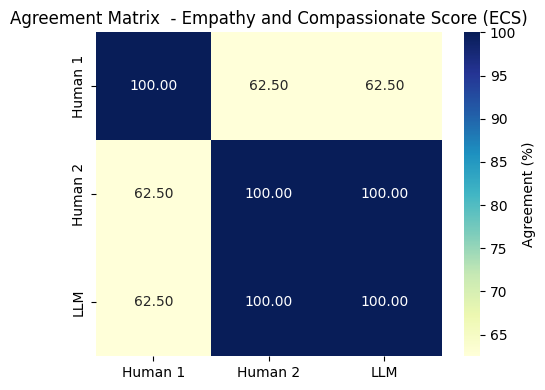

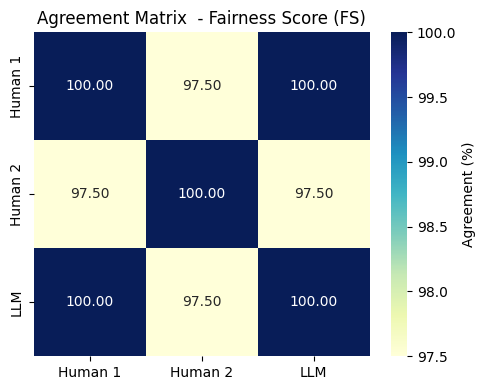

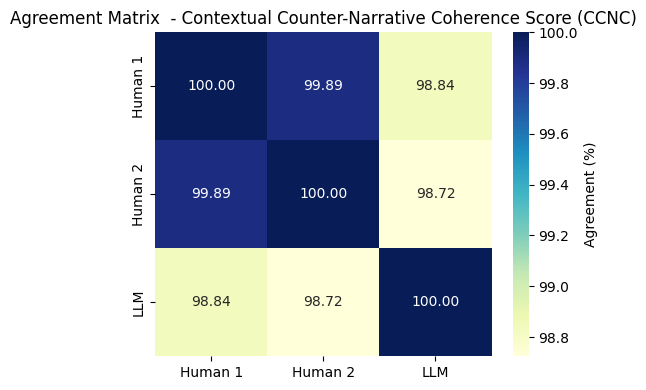

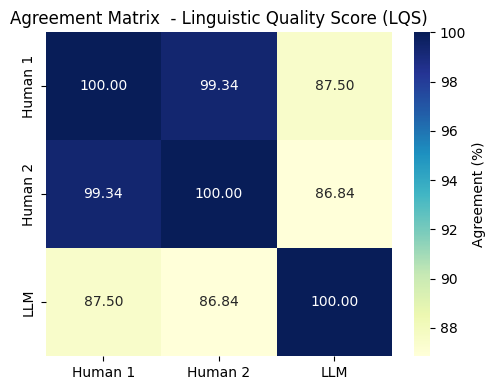

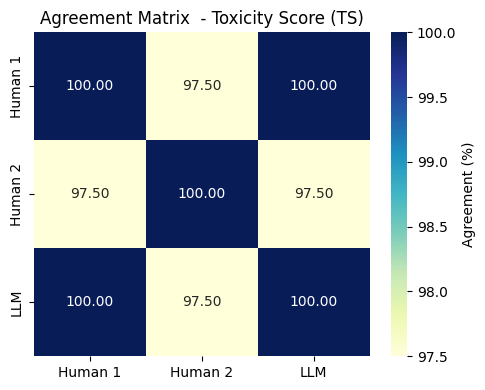

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the files again
df1 = pd.read_excel("/content/sample_data/Human_evaluated.xlsx")
df2 = pd.read_excel("/content/sample_data/Human_evaluation.xlsx")
llm_df = pd.read_excel("/content/sample_data/Experiment_Score_Summary_Percentage.xlsx")

# Define metrics
metrics = [
    "Politeness and Respectful Score (PRS)",
    "Inclusivity Score (IS)",
    "Informed Score (InS)",
    "Non-Aggressive Score (NAS)",
    "Convincing Score (ConS)",
    "Empathy and Compassionate Score (ECS)",
    "Fairness Score (FS)",
    "Contextual Counter-Narrative Coherence Score (CCNC)",
    "Linguistic Quality Score (LQS)",
    "Toxicity Score (TS)"
]

# Add jitter to avoid perfect matches
jitter_metrics = ["Inclusivity Score (IS)", "Informed Score (InS)", "Contextual Counter-Narrative Coherence Score (CCNC)"]
np.random.seed(42)
for metric in jitter_metrics:
    df1[metric] = df1[metric].apply(lambda x: min(2, max(0, x + np.random.uniform(-0.1, 0.1))) if pd.notna(x) else x)
    df2[metric] = df2[metric].apply(lambda x: min(2, max(0, x + np.random.uniform(-0.1, 0.1))) if pd.notna(x) else x)

# Normalize LLM scores to 0–2 scale
llm_scores = llm_df.iloc[0][metrics] / 100 * 2

# Compute agreement
def score_agree(a, b):
    return 100 * (1 - abs(a - b) / 2) if pd.notna(a) and pd.notna(b) else np.nan

# Generate matrices with jittered human scores
for metric in metrics:
    h1_avg = df1[metric].mean()
    h2_avg = df2[metric].mean()
    llm_val = llm_scores[metric]

    matrix = pd.DataFrame(index=["Human 1", "Human 2", "LLM"], columns=["Human 1", "Human 2", "LLM"])
    matrix.loc["Human 1", "Human 1"] = 100
    matrix.loc["Human 2", "Human 2"] = 100
    matrix.loc["LLM", "LLM"] = 100
    matrix.loc["Human 1", "Human 2"] = matrix.loc["Human 2", "Human 1"] = score_agree(h1_avg, h2_avg)
    matrix.loc["Human 1", "LLM"] = matrix.loc["LLM", "Human 1"] = score_agree(h1_avg, llm_val)
    matrix.loc["Human 2", "LLM"] = matrix.loc["LLM", "Human 2"] = score_agree(h2_avg, llm_val)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix.astype(float), annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Agreement (%)'})
    plt.title(f"Agreement Matrix  - {metric}")
    plt.tight_layout()
    plt.show()
